## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser.

----

This notebook performs Bayesian Optimizaion using GPytorch of the Lund string model parameters that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{1}{z^{1+r_Q b m_Q^2}}(1-z)^{a'_i} \exp \left(-\frac{b m_{\perp}^2}{z}\right),
$$

As well as other important flavor and shower parameters. For detailed description of these parameters, see my overleaf writeup.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [292]:
import numpy as np
from scipy.stats import qmc
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [259]:
MAX_PROB = 4.0
PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,MAX_PROB],
        'StringFlav:ProbStoUD':[0,MAX_PROB],
        'StringFlav:probQQtoQ':[0,MAX_PROB],
        'StringFlav:probSQtoQQ':[0,MAX_PROB],
        'StringFlav:ProbQQ1toQQ0':[0,MAX_PROB],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

param_names = list(PARAM_DICT.keys())
print(len(PARAM_DICT))

15


## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [373]:
def make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 2500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {rFactC}\n\n")
        f.write(f"StringZ:rFactB = {rFactB}\n\n")
        f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        f.write(f"StringZ:aExtraDiquark = {aExtraDiquark}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [374]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [375]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

## Gaussian Process Regression

A data set $\mathcal{D}= \left\{ \mathbf{x}, \mathbf{y} \right\} = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

The assumption is that the actual observations are a noise-corrupted value of the true model:
$$
y = f(x) + \varepsilon, \tag{1}
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise. FOr example, the model could be $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$.  

In general, the posterior predictive distribution marginalizes over the model parameters $w$:

$$ p(y \mid x, \mathcal{D}) = \int p(y, w \mid x, \mathcal{D}) d w = \int p(y \mid x, w) p(w \mid \mathcal{D}) dw \tag{2}$$

Using Eq. (1), one can write the likelihood, which is Gaussian

$$p(y \mid w) = p(y \mid x, w) = \mathcal{N}(y; f(x), \sigma^2)$$

However, the integral in Eq. (1) is intractable in closed form. The trick is realizing that the first term in Eq. (1) is a Gaussian. Furthermore, $p(w \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid w) p(w)}{Z}$ is a product of Gaussians normalized by a Gaussian, so it is also a Gaussian, therefore, $p(y \mid x, \mathcal{D}) $ is a Gaussian.


$p(\mathbf{y}\mid\mathbf{x})$ is thus fully specified by the Kernel, and it starts out being the Gaussian process prior
$$ p(y_1, ... y_n \mid x_1, .., x_n)  = \mathcal{N}(y;0, \Sigma) \tag{3}$$ 
Where, $\Sigma$ can be decomposed as

$$ \Sigma =  \begin{pmatrix}
k & k_* \\
k_*^T & k_{**}
\end{pmatrix} $$

Another way to write Eq. (3) is
$$ \left[\begin{array}{c}
f\left(x^*\right) \\
f\left(x_1\right) \\
\vdots \\
f\left(x_n\right)
\end{array}\right] \sim N\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right],\left[\begin{array}{cc}
k\left(x^*, x^*\right) & k\left(x^*, \mathbf{x}\right)^T \\
k\left(x^*, \mathbf{x}\right) & K_{\mathbf{x x}}
\end{array}\right]\right)$$


where the the kernel components $k$'s are functions of $x_1,...,x_n$ and $x_*$
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$

The most commonly used kernel is the RBF kernel  $\Sigma_{x,y} = k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`

Now, given a new data point $x^*$, $y^*$ can be predicted using a closed form of the posterior predictive distribution
$$
y_* | \mathcal{D}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)), \tag{4}
$$

That is, the Gaussian process at a new point $\mathbf{x}^*$ is
$$p\left(f\left(\mathbf{x}^*\right) \mid \mathbf{y}\right)=\mathcal{N}\left(f\left(\mathbf{x}^*\right) \mid m \left(\mathbf{x}^*\right), \sigma \left(\mathbf{x}^*\right)\right)$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$

$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$



In [413]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        # self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))
        self.covar_module = ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

A rule of thumb is to choose the training set size to be 10-20 times the number of parameters. This gives us 150-300 examples.

In [441]:
SUBSAMPLE = -1
train_df = pd.read_csv('LHS_DF_with_chi2.csv')[:SUBSAMPLE]
# train_df = pd.read_csv('ALL_PRAMS_DF_with_chi2.csv')
train_df.head()

Unnamed: 0.1  Unnamed: 0  StringZ:aLund  StringZ:bLund  StringZ:rFactC  \
0             2           2       1.018815       1.907645        0.593628   
1             3           3       0.988716       0.471020        1.764055   
2             4           4       0.444193       1.834390        0.123916   
3             8           8       0.463673       1.647624        1.484369   
4             9           9       1.034734       1.489235        0.438249   

   StringZ:rFactB  StringZ:aExtraSQuark  StringZ:aExtraDiquark  \
0        1.285956              0.469747               0.616684   
1        0.462788              1.921271               0.872170   
2        1.964130              0.733800               1.430367   
3        0.706367              1.915505               1.579792   
4        0.517065              0.490425               1.223198   

   StringPT:sigma  StringPT:enhancedFraction  StringPT:enhancedWidth  \
0        0.321632                   0.093016                3.353963   
1        0.855325                   0.969504                1.399415   
2        0.223075                   0.812724                2.754028   
3        0.026979                   0.088789                2.203874   
4        0.590138                   0.841279                3.643448   

   StringFlav:ProbStoUD  StringFlav:probQQtoQ  StringFlav:probSQtoQQ  \
0              2.502734              1.611805               3.728123   
1              3.818593              1.148781               2.588958   
2              3.016335              0.074418               0.043306   
3              3.153978              2.098117               0.935123   
4              3.529870              0.183085               1.555951   

   StringFlav:ProbQQ1toQQ0  TimeShower:alphaSvalue  TimeShower:pTmin  \
0                 3.530520                0.150097          1.086739   
1                 2.094627                0.114196          1.930516   
2                 2.476595                0.100424          1.358620   
3                 0.565346                0.126309          0.828173   
4                 0.421221                0.160989          1.183123   

        chi2  
0  38.989016  
1  40.164803  
2  29.317393  
3  42.062218  
4  39.716942

In [257]:
train_df.describe()

Unnamed: 0.1   Unnamed: 0  StringZ:aLund  StringZ:bLund  \
count   2148.000000  2148.000000    2148.000000    2148.000000   
mean    2474.600559  2474.600559       0.967550       1.150754   
std     1407.228210  1407.228210       0.574628       0.515264   
min        2.000000     2.000000       0.000757       0.200019   
25%     1237.500000  1237.500000       0.456235       0.716932   
50%     2497.500000  2497.500000       0.960681       1.170419   
75%     3738.500000  3738.500000       1.449723       1.593148   
max     4966.000000  4966.000000       1.999840       1.999032   

       StringZ:rFactC  StringZ:rFactB  StringZ:aExtraSQuark  \
count     2148.000000     2148.000000           2148.000000   
mean         0.984285        0.976983              1.014280   
std          0.577392        0.580295              0.577936   
min          0.001319        0.000595              0.001198   
25%          0.485317        0.474782              0.525525   
50%          0.984158        0.963313              1.014947   
75%          1.472815        1.481971              1.509191   
max          1.998945        1.999374              1.999794   

       StringZ:aExtraDiquark  StringPT:sigma  StringPT:enhancedFraction  \
count            2148.000000     2148.000000                2148.000000   
mean                0.973088        0.557530                   0.520665   
std                 0.579404        0.284337                   0.289044   
min                 0.000066        0.002492                   0.000720   
25%                 0.473873        0.318254                   0.276856   
50%                 0.972272        0.590155                   0.529974   
75%                 1.476332        0.805902                   0.778022   
max                 1.999412        0.999744                   0.999888   

       StringPT:enhancedWidth  StringFlav:ProbStoUD  StringFlav:probQQtoQ  \
count             2148.000000           2148.000000           2148.000000   
mean                 2.557065              1.943075              1.998245   
std                  0.878386              1.179048              1.164232   
min                  1.002470              0.001232              0.001278   
25%                  1.802306              0.895631              1.003590   
50%                  2.558531              1.940536              2.025128   
75%                  3.319240              2.950523              3.007061   
max                  3.999811              3.999675              3.998602   

       StringFlav:probSQtoQQ  StringFlav:ProbQQ1toQQ0  TimeShower:alphaSvalue  \
count            2148.000000              2148.000000             2148.000000   
mean                1.982008                 1.986946                0.123908   
std                 1.150876                 1.157153                0.048832   
min                 0.001533                 0.003851                0.060011   
25%                 0.984325                 0.991808                0.084033   
50%                 1.992738                 1.995830                0.112906   
75%                 2.977555                 2.998031                0.150211   
max                 3.998643                 3.994812                0.249931   

       TimeShower:pTmin         chi2  
count       2148.000000  2148.000000  
mean           1.153417    39.617433  
std            0.513942     8.754827  
min            0.100453     5.622573  
25%            0.748500    35.537392  
50%            1.188820    40.322606  
75%            1.590690    44.400032  
max            1.999538    72.316498

In [442]:
train_x = train_df[param_names].to_numpy()
train_y = train_df['chi2'].to_numpy()

In [443]:
train_x.shape

(2148, 15)

In [444]:
train_y.shape

(2148,)

### (Optional) Make new dataset here in jupyter

In [154]:
def make_train_dataset(PARAM_DICT, points):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']
    
    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)
        
        chi2 = true_objective_func(*row)
        row.append(chi2)
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [107]:
train_df_new = make_train_dataset(PARAM_DICT, 75)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Traceback (most recent call last):
  File "/usr/local/bin/rivet", line 213, in <module>
    all_analyses = rivet.AnalysisLoader.analysisNames() #< excludes aliases
KeyboardInterrupt


[0]
looping over 1 sim yoda files...



  0%|                                                     | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


FileNotFoundError: ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

In [499]:
train_df_new.describe()

StringZ:aLund  StringZ:bLund  StringZ:rFactC  StringZ:rFactB  \
count      75.000000      75.000000       75.000000       75.000000   
mean        1.024165       1.054585        1.084380        0.991521   
std         0.574277       0.583546        0.600075        0.565680   
min         0.023940       0.011581        0.009009        0.050850   
25%         0.513596       0.582569        0.496514        0.488645   
50%         1.051557       1.028745        1.090294        0.934820   
75%         1.524026       1.650432        1.588286        1.475464   
max         1.994026       1.918090        1.996329        1.998909   

       StringZ:aExtraSQuark  StringZ:aExtraDiquark  StringPT:sigma  \
count             75.000000              75.000000       75.000000   
mean               0.911402               1.187171        0.490522   
std                0.518722               0.544235        0.277581   
min                0.072157               0.104720        0.003080   
25%                0.478093               0.775668        0.244520   
50%                0.937415               1.339954        0.486186   
75%                1.284238               1.604564        0.755765   
max                1.983874               1.999732        0.987084   

       StringPT:enhancedFraction  StringPT:enhancedWidth  \
count                  75.000000               75.000000   
mean                    0.415595                2.509142   
std                     0.267377                0.893851   
min                     0.014562                1.047797   
25%                     0.196665                1.646296   
50%                     0.404398                2.444228   
75%                     0.575821                3.420676   
max                     0.993511                3.988504   

       StringFlav:ProbStoUD  StringFlav:probQQtoQ  StringFlav:probSQtoQQ  \
count             75.000000             75.000000              75.000000   
mean               1.991589              2.035131               1.934464   
std                1.122669              1.258252               1.118541   
min                0.019426              0.077434               0.072592   
25%                1.045230              0.859674               1.091707   
50%                1.939143              2.189786               1.724426   
75%                3.015661              3.187998               2.881929   
max                3.985817              3.866482               3.942006   

       StringFlav:ProbQQ1toQQ0  TimeShower:alphaSvalue  TimeShower:pTmin  \
count                75.000000               75.000000         75.000000   
mean                  1.983899                0.162765          0.980156   
std                   1.089561                0.056914          0.520526   
min                   0.063163                0.062414          0.112414   
25%                   0.982966                0.104994          0.502800   
50%                   2.084855                0.178182          0.959600   
75%                   2.903214                0.209231          1.298491   
max                   3.824085                0.247729          1.967896   

            chi2  
count  75.000000  
mean   39.612894  
std    10.400232  
min    12.094384  
25%    33.589837  
50%    38.086453  
75%    44.197712  
max    72.540827

In [155]:
train_x = train_df_new[param_names].to_numpy()
train_y = train_df_new['chi2'].to_numpy()
train_x.shape

NameError: name 'train_df_new' is not defined

## Define model and likelihood

The surrogate model of the output $\mathbf{y}$ is $\mathbf{f}=\left[f\left(\mathbf{x}_1\right), \ldots, f\left(\mathbf{x}_N\right)\right]^{\top}$ and it follows a multivariate Gaussian $p(\mathbf{f})=\mathcal{N}(\mathbf{f} \mid \mathbf{m}, \mathbf{K})$ where $\mathbf{m}=\left[m\left(\mathbf{x}_1\right), \ldots, m\left(\mathbf{x}_N\right)\right]^{\top}$ is the mean value function and $\mathbf{K}$ is the kernel matrix $[\mathbf{K}]_{i j}=\kappa\left(\mathbf{x}_i, \mathbf{x}_j\right)$. The likelihood in GPytorch maps from the latent function values $\mathbf{f}$ to the observed labels $\mathbf{y}$. Since we assume that the labels are noise-corrupted observations of the true model,
$$y(\mathbf{x})=f(\mathbf{x})+\epsilon, \quad \epsilon \sim N\left(0, \sigma_n^2 \mathbf{I}\right)$$
and therefore
$$ p(\mathbf{y} \mid \mathbf{f})=\mathcal{N}\left(\mathbf{y} \mid \mathbf{f}, \sigma^2 \mathbf{I}\right)$$

where $\sigma^2$ is the likelihood noise variance.

In [445]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()

In [415]:
model.train_targets

tensor([9.9182, 5.6226, 8.2049, 8.0580, 9.0899, 9.3381, 6.1779, 8.8666, 6.5599,
        7.7394, 7.4465, 7.9145, 9.1677, 5.7637], dtype=torch.float64)

In [416]:
model.train_inputs[0].shape

torch.Size([14, 15])

In [417]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        self.min = PARAM_DICT[pre_postfix][0]
        self.max = PARAM_DICT[pre_postfix][1]
        
    def uniform(self):
        return torch.tensor(np.random.uniform(
                low=self.min,
                high=self.max,
                size=self.size))

    def linspace(self):
        return torch.linspace(start=self.min,
                end=self.max,
                steps=self.size)

    def scale_sample(self, sample):
        return sample * (self.max - self.min) + self.min

In [418]:
def make_sobol_candidates(PARAM_DICT, size):
    num_params = len(PARAM_DICT)
    
    # Create a single Sobol sampler for all dimensions
    sampler = qmc.Sobol(d=num_params, scramble=True)
    
    # Generate samples
    samples = sampler.random(n=size)
    
    # Scale samples for each parameter
    scaled_samples = np.empty_like(samples)
    for ind, (key, val) in enumerate(PARAM_DICT.items()):
        param_name, range_ = key, val
        param_postfix = param_name.split(':')[1]
        param_sampler = Sample_param(param=param_postfix, size=size)
        scaled_samples[:, ind] = param_sampler.scale_sample(samples[:, ind])
    
    return torch.tensor(scaled_samples)


In [419]:
sobol_candidates = make_sobol_candidates(PARAM_DICT,1000)
print(sobol_candidates[:,1].min())

tensor(0.2016, dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


In [420]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates[0])

tensor([0.2809, 0.9666, 1.5483, 1.2605, 0.5845, 1.5705, 0.3498, 0.1979, 3.4610,
        3.7996, 0.8683, 0.6278, 3.6500, 0.1308, 1.2073], dtype=torch.float64)


In [421]:
x_candidates_aLund =x_candidates[:,0]
print(x_candidates_aLund)

tensor([0.2809, 1.5912], dtype=torch.float64)


In [388]:
# make sure you can call model on x_candidates
model.predict(x_candidates)

MultivariateNormal(loc: torch.Size([2]))

In [389]:
def compare_uniform_sobol(PARAM_DICT,size):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    uniform_candidates = make_x_candidates(PARAM_DICT,size)
    a_uniform = uniform_candidates[:,0]
    b_uniform = uniform_candidates[:,1]
    ax[0].scatter(a_uniform, b_uniform)
    ax[0].set_title('Uniform MC')
    
    sobol_candidates = make_sobol_candidates(PARAM_DICT,size)
    a_sobol=sobol_candidates[:,0]
    b_sobol=sobol_candidates[:,1]
    ax[1].scatter(a_sobol, b_sobol)
    ax[1].set_title('Sobol')
    
    for i in range(2):
        ax[i].set_xlabel('aLund')
        ax[i].set_ylabel('bLund')
    plt.tight_layout()
    plt.show()

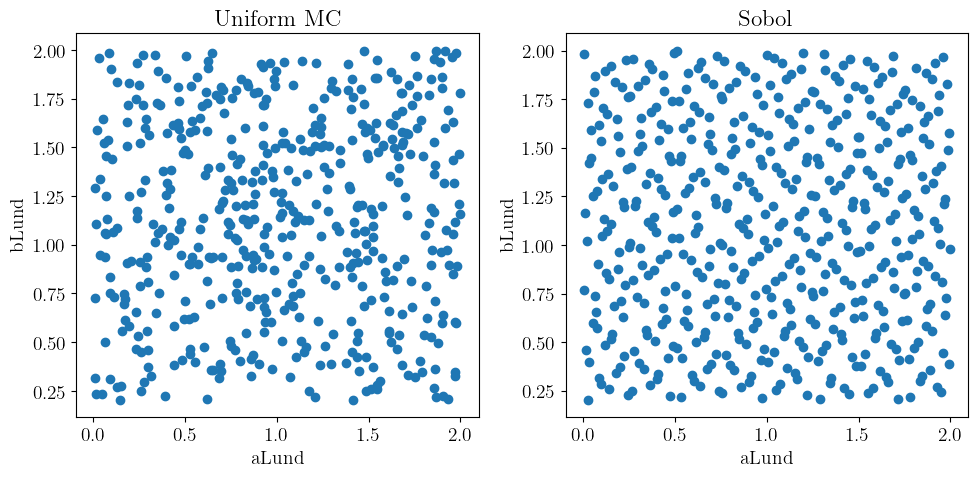

In [369]:
compare_uniform_sobol(PARAM_DICT,500)

In [390]:
def make_multidim_xstar(param,size):

    x_star0 = Sample_param(param,size).linspace()
    # empty = np.ones((size,15))
    empty = make_x_candidates(PARAM_DICT, size)
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    # print(empty)
    return torch.tensor(empty)

In [391]:
x_star = make_multidim_xstar(param='bLund',size=2)
x_star

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


tensor([[1.7990, 0.2000, 1.7004, 1.7913, 0.6428, 1.2323, 0.4865, 0.0626, 1.3514,
         0.9003, 2.8530, 0.1952, 3.7858, 0.0665, 1.8655],
        [1.4818, 2.0000, 1.6433, 1.9680, 0.5621, 1.0249, 0.2086, 0.8499, 2.2825,
         1.8680, 2.6426, 0.2238, 1.9430, 0.0618, 0.2708]], dtype=torch.float64)

In [392]:
train_x_model = model.train_inputs[0].numpy()
train_x_model[:,0]

array([1.01881549, 0.98871636, 0.44419299, ..., 1.36853655, 1.53483804,
       0.42838925])

In [446]:
def plot_model_param(model,param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()
    
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(param,200)
        
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()
    
    print(pred.shape)

    x_star_param =x_star[:,param_index].numpy()
    plt.plot(x_star_param, pred, label='GP Mean Prediction', color='red')
    plt.fill_between(x_star_param, lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x_param, train_y, 'k*', label='Observed Data', alpha=0.5)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel(r'$\lambda$')
    plt.show()

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


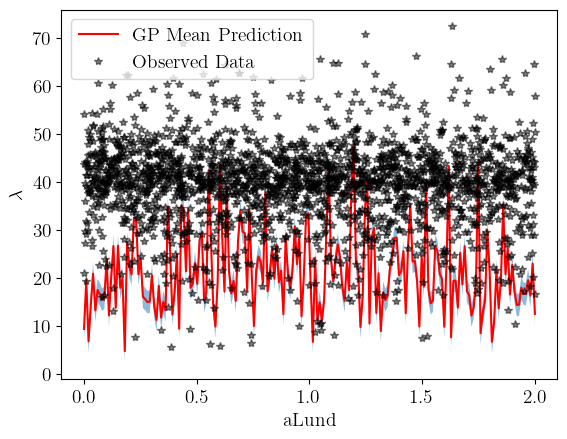

In [447]:
plot_model_param(model, 'aLund')

### Redefine model with reduced training data

In [430]:
train_df = pd.read_csv('LHS_DF_with_chi2.csv')[:SUBSAMPLE]
train_x = train_df[param_names].to_numpy()
train_y = train_df['chi2'].to_numpy()

mask = train_y < 20
train_y = train_y[mask]
train_x = train_x[mask]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()
print(train_x.shape)

torch.Size([68, 15])


### Observe untrained (default) GP model parameters

In [431]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [432]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


## Tune hyperparameters of GP model (train model)

We tune the hyperparameters by maximizing the marginal log likelihood (MLL) (i.e. treating -MLL as the loss and minimizing it)

$$ \text{MLL} = p_f(\mathbf{y} \mid \mathbf{X})=\int p(\mathbf{y} \mid f(\mathbf{X})) p(f(\mathbf{X}) \mid \mathbf{X}) d f $$

For the Gaussian process this equates to 
$$p(\mathbf{y} \mid \mathbf{X})=\mathcal{N}\left(\mathbf{y} \mid \mathbf{m}, \mathbf{K}+\sigma^2 \mathbf{I}\right)$$
$$ \mathcal{L}= - \text{MLL}$$

In [448]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
                print('Epoch %d/%d - Loss: %.3f   lengthscale: %s   noise: %.3f\n' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.tolist()[0],
        model.likelihood.noise.item()
    ))
        loss.backward()
        optimizer.step()

In [449]:
train_model(model, train_x, train_y, 50,print_=True)

Epoch 1/50 - Loss: 283.220   lengthscale: [0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453]   noise: 0.693

Epoch 2/50 - Loss: 211.713   lengthscale: [0.7443966600599905, 0.7443966600578557, 0.7443966600599694, 0.7443966600601875, 0.7443966600598696, 0.7443966600602046, 0.7443966600328656, 0.7443966600320465, 0.7443966600640433, 0.7443966600652538, 0.744396660065211, 0.7443966600652656, 0.7443966600652718, 0.7443966590832092, 0.7443966600580598]   noise: 0.744

Epoch 3/50 - Loss: 158.756   lengthscale: [0.7973575151309343, 0.797306052446235, 0.7973554577447429, 0.7973520534777627, 0.7973302647477221, 0.797355534893207, 0.7971197264959233, 0.7970328266924281, 0.797394255825925, 0.7974184531077813, 0.7974070695786585, 0.7974159682401872, 0.7

In [450]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([2.2996], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(1.7790, dtype=torch.float64)
covar_module.raw_outputscale tensor(1.8393, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[1.6200, 1.5697, 1.6105, 1.6173, 1.5865, 1.6267, 1.3731, 1.2612, 1.5955,
         1.6267, 1.6213, 1.6486, 1.6356, 0.8524, 1.5992]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


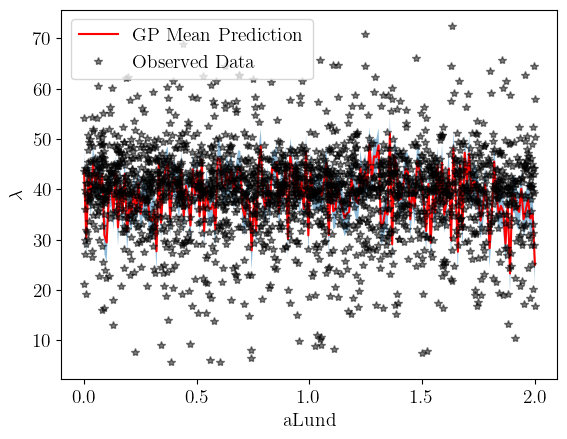

In [451]:
plot_model_param(model, 'aLund')

In [404]:
def get_observed_best_parameters(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    observed_min = train_x[train_y.argmin()]
    param_names = list(PARAM_DICT.keys())
    param_names = [param_name.split(':')[1] for param_name in param_names]
    best_params_dict = {k: v for k, v in zip(param_names, observed_min)}
    return best_params_dict

## Validate the results and observe the data-MC agreement is bad at this point

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [405]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
        f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
        f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
        f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

----

# Bayesian Optimization

Bayesian optimization is the optimization of a complex black box function (such as an objective function) $f(x)$ through iterative pointwise queries. The objective function is expensive, so it cannot be exhaustively evaluated. The function is also noisy, so repeated queries may yield different results.

We wish to find an optimal set of parameters $\mathbf{x}^*$ of the objective function

$$ \mathbf{x}^* = \text{arg max}_{\mathbf{x}\in \mathcal{R}^D} f(\mathbf{x})$$

In a nutshell, the algorithm works by forming a surrogate model $\hat{f}(x)$ by a GP of the objective function $f(x)$. 
$$ \hat{f}(\mathbf{x}) \sim \text{GP} (m(\mathbf{x}), k(\mathbf{x}))$$

We choose the next point through an acquisition function. We then evaluate and update the model, and repeat.

1. Construct a GP surrogate (regression) model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function $\alpha(x)$
$$
x_{new} = \arg\max\limits_x \alpha(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [406]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
        return ei


In [283]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates)
next_x = x_candidates[0]
a = torch.cat([train_x, next_x.unsqueeze(0)])
print(a)

tensor([[0.9328, 0.8522, 0.1270, 0.0351, 1.6378, 0.9221, 0.8104, 0.3145, 3.5090,
         3.3686, 0.3537, 0.0456, 1.1403, 0.2009, 1.2236],
        [1.2235, 1.9919, 1.4995, 1.8863, 0.5952, 1.8290, 0.0401, 0.3057, 1.3191,
         3.0363, 3.8224, 0.1196, 3.2081, 0.2340, 1.6241]], dtype=torch.float64)
tensor([[0.3847, 1.2477, 0.1934, 1.9360, 1.3148, 1.0779, 0.9436, 0.9316, 3.5823,
         1.6980, 3.6605, 1.5323, 2.1654, 0.2073, 1.5966],
        [0.5588, 1.0878, 0.8160, 1.5550, 1.8498, 0.5195, 0.9612, 0.9664, 3.7693,
         1.4510, 2.9147, 0.5572, 2.9496, 0.1977, 1.4282],
        [0.7389, 1.2623, 0.7108, 0.1272, 1.7630, 1.1332, 0.8248, 0.9874, 3.7733,
         1.7727, 0.7961, 2.3526, 2.2570, 0.2285, 0.3529],
        [0.2251, 1.3746, 0.3742, 0.3128, 1.7786, 0.3958, 0.8746, 0.9995, 3.9384,
         2.4748, 0.3989, 2.7018, 3.4526, 0.1081, 0.1216],
        [1.4995, 1.5390, 0.6748, 1.8491, 1.0289, 0.4986, 0.9323, 0.9446, 3.4323,
         1.1603, 1.7350, 2.4089, 3.4972, 0.1887, 1.6385],
     

In [452]:
def BayesOpt_all_params(model, 
                        train_x, 
                        train_y, 
                        n_iterations, 
                        retrain_gp=False,
                        print_=False,
                       save_model=False):
    # Use the Adam optimizer

    model.eval()
    likelihood.eval()
    
    Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
    next_y = true_objective_func(*Monash_candidate)
    print(f'objective function at the Monash point = {next_y}')
    train_x = torch.cat([train_x, Monash_candidate.unsqueeze(0)])
    next_y = torch.tensor([next_y])
    train_y = torch.cat([train_y, next_y])
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    train_model(model, train_x, train_y, 25, print_=print_)
    
    for iteration in range(n_iterations):

        # x_candidates = make_x_candidates(PARAM_DICT,1000)
        x_candidates = make_sobol_candidates(PARAM_DICT,1000)
        ei = expected_improvement(model, train_y, x_candidates)
        ei_argmax = ei.argmax()
        next_x = x_candidates[ei_argmax]
        next_y = true_objective_func(*next_x)
        train_x = torch.cat([train_x, next_x.unsqueeze(0)])
        next_y = torch.tensor([next_y])

        print(f'epoch {iteration} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # retrain model with updated data
        if retrain_gp:
            model.train()
            train_model(model, train_x, train_y, 25, print_=print_)

    train_size=train_x.shape[0]
    if save_model:
        path = f'models/GPytorch_all_params_model_Niter_{n_iterations}_trainsize_{train_size}.pth'
        torch.save(model.state_dict(), path)
        
        

In [453]:
BayesOpt_all_params(model, 
                    train_x, 
                    train_y, 
                    200, 
                    retrain_gp=True,
                    print_=False,
                   save_model=False)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:49:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 00:49:36
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 00:49:36, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.26it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.32  0.9856  0.043341  0.033429       154.0
1  0.005  0.010  23.76  1.9008  0.180127  0.283214       297.0
2  0.010  0.015  21.52  1.7216  0.268280  0.677067       269.0
3  0.015  0.020  16.24  1.2992  0.282453  0.988860       203.0
4  0.020  0.025  15.12  1.2096  0.337349  1.511368       189.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 1.4212034720608162
objective function at the Monash point = 1.4212034720608162


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:49:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:49:49
Cross-section = 3.951081e+04 pb
Rivet run completed at 2024-06-28 00:49:49, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  2.173914  2.362949  0.013532  0.016970         2.0
2  0.010  0.015  5.434782  5.907372  0.067323  0.169108         5.0
3  0.015  0.020  3.260870  3.544424  0.056009  0.193801         3.0
4  0.020  0.025  6.521740  7.088848  0.145841  0.655748         6.0
 new data ke

objective function = 6.705028651078562
epoch 0 next_x = tensor([1.2281, 0.8869, 0.2681, 1.9064, 0.7358, 0.3941, 0.9073, 0.9666, 3.8885,
        0.9992, 0.1637, 2.9150, 0.1058, 0.2041, 1.0236], dtype=torch.float64), next_y = tensor([6.7050], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:50:02
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:50:02
Cross-section = 3.845948e+04 pb
Rivet run completed at 2024-06-28 00:50:02, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.793104  23.781212  0.034705  0.018965         8.0
1  0.005  0.010   6.896552  11.890608  0.055470  0.093064         4.0
2  0.010  0.015  13.793104  23.781212  0.180555  0.479401         8.0
3  0.015  0.020  13.793104  23.781212  0.249401  0.906646         8.0
4  0.020  0.025  10.344828  17.835909  0.234871  1.072175         6.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/RE

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:50:15
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:50:16
Cross-section = 4.068683e+04 pb
Rivet run completed at 2024-06-28 00:50:16, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.00it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.414079  0.171461  0.001607  0.001248         1.0
1  0.005  0.010  2.484472  1.028767  0.020670  0.035178         6.0
2  0.010  0.015  5.383022  2.228995  0.066271  0.166385        13.0
3  0.015  0.020  4.968944  2.057534  0.087772  0.312769        12.0
4  0.020  0.025  4.140786  1.714612  0.095023  0.437660        10.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:50:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:50:29
Cross-section = 3.985621e+04 pb
Rivet run completed at 2024-06-28 00:50:29, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx        sumwx2  numEntries
0  0.000  0.005  0.884956  0.783147  0.000023  1.154564e-07         1.0
1  0.005  0.010  4.424778  3.915734  0.035809  5.911112e-02         5.0
2  0.010  0.015  4.424778  3.915734  0.058735  1.574153e-01         5.0
3  0.015  0.020  9.734514  8.614612  0.169547  5.944160e-01        11.0
4  0.020  0.025  0.884956  0.783147  0.019270  8.391776e-02 

objective function = 6.9009225847608775
epoch 3 next_x = tensor([1.1085, 1.7275, 1.6130, 0.2718, 0.4111, 0.4192, 0.9741, 0.9137, 3.7617,
        0.9012, 3.3970, 0.0650, 3.9739, 0.2112, 1.9357], dtype=torch.float64), next_y = tensor([6.9009], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:50:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:50:42
Cross-section = 3.986294e+04 pb
Rivet run completed at 2024-06-28 00:50:42, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.91it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.30it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.048458   6.210096  0.015109  0.010195         8.0
1  0.005  0.010  11.453744  10.091404  0.085555  0.134540        13.0
2  0.010  0.015  10.572688   9.315144  0.132853  0.340637        12.0
3  0.015  0.020  14.096916  12.420192  0.246707  0.866399        16.0
4  0.020  0.025  14.096916  12.420192  0.309156  1.359627        16.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', 

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:50:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:50:55
Cross-section = 3.926218e+04 pb
Rivet run completed at 2024-06-28 00:50:55, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.33it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.938272   6.096632  0.008187  0.004127         4.0
1  0.005  0.010   4.938272   6.096632  0.036211  0.054507         4.0
2  0.010  0.015   2.469136   3.048316  0.029993  0.073385         2.0
3  0.015  0.020   8.641976  10.669104  0.150516  0.528808         7.0
4  0.020  0.025  11.111112  13.717420  0.252949  1.156814         9.0


objective function = 6.645995764143176
epoch 5 next_x = tensor([1.0526, 0.8949, 1.5840, 1.1622, 0.3845, 0.2134, 0.9604, 0.9869, 3.6917,
        3.8186, 3.3600, 0.9727, 0.6900, 0.1706, 0.5765], dtype=torch.float64), next_y = tensor([6.6460], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:51:08
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 00:51:08
Cross-section = 3.619002e+04 pb
Rivet run completed at 2024-06-28 00:51:08, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.54it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.677420  31.217480  0.030441  0.026353         3.0
1  0.005  0.010   6.451612  20.811657  0.034712  0.037382         2.0
2  0.010  0.015  16.129032  52.029121  0.198198  0.495724         5.0
3  0.015  0.020   6.451612  20.811657  0.120641  0.451437         2.0
4  0.020  0.025  29.032261  93.652443  0.631793  2.760682         9.0


objective function = 9.33200162258241
epoch 6 next_x = tensor([1.7082, 1.3325, 1.8467, 1.3686, 0.7230, 1.8429, 0.9398, 0.9961, 3.9346,
        1.7754, 2.3548, 3.5549, 3.1845, 0.1323, 0.1056], dtype=torch.float64), next_y = tensor([9.3320], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:51:21
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:51:21
Cross-section = 3.970756e+04 pb
Rivet run completed at 2024-06-28 00:51:21, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.39it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.185792   2.388844  0.008323  0.006341         2.0
1  0.005  0.010   8.743170   9.555376  0.066082  0.103079         8.0
2  0.010  0.015  15.300546  16.721909  0.190101  0.478921        14.0
3  0.015  0.020   7.650274   8.360956  0.134878  0.478968         7.0
4  0.020  0.025   6.557378   7.166532  0.145780  0.649344         6.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:51:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:51:34
Cross-section = 3.802147e+04 pb
Rivet run completed at 2024-06-28 00:51:34, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.68it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.0   16.0  0.019493  0.015509         4.0
1  0.005  0.010  18.0   36.0  0.124484  0.179405         9.0
2  0.010  0.015  18.0   36.0  0.220916  0.548575         9.0
3  0.015  0.020  12.0   24.0  0.206834  0.717952         6.0
4  0.020  0.025   6.0   12.0  0.129198  0.557084         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

objective function = 6.891842303270154
epoch 8 next_x = tensor([0.6607, 1.9139, 0.3917, 0.2745, 0.2190, 1.3416, 0.9914, 0.9710, 3.7580,
        0.9139, 2.0919, 1.4856, 0.4493, 0.1317, 0.8428], dtype=torch.float64), next_y = tensor([6.8918], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:51:47
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:51:47
Cross-section = 3.963277e+04 pb
Rivet run completed at 2024-06-28 00:51:47, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.12it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.091370   6.184132  0.016651  0.011528         6.0
1  0.005  0.010  11.167512  11.337576  0.091306  0.153812        11.0
2  0.010  0.015   7.106598   7.214820  0.094041  0.250968         7.0
3  0.015  0.020   7.106598   7.214820  0.123701  0.433724         7.0
4  0.020  0.025   2.030456   2.061378  0.049188  0.238424         2.0


objective function = 6.267506023548874
epoch 9 next_x = tensor([1.6910, 1.7300, 1.8224, 1.4144, 1.6222, 0.4129, 0.9875, 0.9863, 3.3789,
        0.5528, 3.4317, 2.6795, 0.6127, 0.1761, 1.4515], dtype=torch.float64), next_y = tensor([6.2675], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:52:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:52:01
Cross-section = 3.916907e+04 pb
Rivet run completed at 2024-06-28 00:52:01, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.48it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.451612   8.324660  0.015955  0.011061         5.0
1  0.005  0.010   5.161290   6.659728  0.039945  0.064012         4.0
2  0.010  0.015   5.161290   6.659728  0.056692  0.126337         4.0
3  0.015  0.020  18.064516  23.309052  0.304202  1.030712        14.0
4  0.020  0.025   7.741936   9.989596  0.175333  0.798458         6.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:52:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:52:14
Cross-section = 4.058988e+04 pb
Rivet run completed at 2024-06-28 00:52:14, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.47it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.084112  6.114072  0.037179  0.025638        28.0
1  0.005  0.010  17.289721  8.079308  0.125795  0.190271        37.0
2  0.010  0.015  15.887850  7.424228  0.201328  0.517444        34.0
3  0.015  0.020  14.485982  6.769152  0.246546  0.844489        31.0
4  0.020  0.025   8.878504  4.148832  0.198336  0.890126        19.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:52:27
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 00:52:27
Cross-section = 3.412986e+04 pb
Rivet run completed at 2024-06-28 00:52:27, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  9.523810  45.351479  0.065868  0.091364         2.0
2  0.010  0.015  4.761904  22.675735  0.053316  0.119390         1.0
3  0.015  0.020  0.000000   0.000000  0.000000  0.000000         0.0
4  0.020  0.025  4.761904  22.675735  0.116464  0.569686         1.0
 new d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:52:40
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 00:52:40
Cross-section = 3.743275e+04 pb
Rivet run completed at 2024-06-28 00:52:40, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.20it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.380952   5.668936  0.000857  0.000062         1.0
1  0.005  0.010  0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015  0.000000   0.000000  0.000000  0.000000         0.0
3  0.015  0.020  2.380952   5.668936  0.037788  0.119947         1.0
4  0.020  0.025  4.761904  11.337868  0.104647  0.461220         2.0
 new d

objective function = 10.735665229141247
epoch 13 next_x = tensor([0.7871, 0.7961, 1.7454, 0.1729, 0.9807, 1.9351, 0.9659, 0.9568, 3.7661,
        0.4775, 3.6692, 1.1945, 0.6815, 0.2131, 1.9087], dtype=torch.float64), next_y = tensor([10.7357], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:52:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:52:53
Cross-section = 4.053809e+04 pb
Rivet run completed at 2024-06-28 00:52:53, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.992556  0.492584  0.002531  0.002176         2.0
1  0.005  0.010  4.962780  2.462918  0.039898  0.065006        10.0
2  0.010  0.015  3.473946  1.724042  0.042673  0.105678         7.0
3  0.015  0.020  5.955334  2.955501  0.101705  0.348980        12.0
4  0.020  0.025  6.451612  3.201793  0.144315  0.650119        13.0
 new data ke

objective function = 6.5032871439593505
epoch 14 next_x = tensor([0.5964, 1.2314, 0.9348, 1.8485, 1.5534, 0.9448, 0.9536, 0.9218, 3.6365,
        3.0326, 2.8646, 1.7576, 3.9763, 0.2101, 0.7955], dtype=torch.float64), next_y = tensor([6.5033], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:53:06
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:53:06
Cross-section = 4.028144e+04 pb
Rivet run completed at 2024-06-28 00:53:06, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.10it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.564102  1.643656  0.007853  0.005160         4.0
1  0.005  0.010  2.564102  1.643656  0.022666  0.040533         4.0
2  0.010  0.015  3.846154  2.465483  0.046547  0.115167         6.0
3  0.015  0.020  4.487180  2.876397  0.082812  0.307344         7.0
4  0.020  0.025  8.974358  5.752796  0.201446  0.907508        14.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:53:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:53:21
Cross-section = 4.118475e+04 pb
Rivet run completed at 2024-06-28 00:53:21, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.89it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.930914  0.409060  0.009469  0.007185        21.0
1  0.005  0.010  7.257502  1.012910  0.053696  0.082721        52.0
2  0.010  0.015  7.676204  1.071347  0.096928  0.247654        55.0
3  0.015  0.020  6.978368  0.973952  0.120514  0.419033        50.0
4  0.020  0.025  8.094906  1.129784  0.180307  0.806512        58.0
 new data ke

objective function = 11.542858272990236
epoch 16 next_x = tensor([1.6966, 1.0987, 0.9821, 0.0509, 1.9919, 0.2482, 0.9591, 0.8285, 3.9230,
        2.7410, 1.9905, 2.3642, 1.9192, 0.1725, 1.7280], dtype=torch.float64), next_y = tensor([11.5429], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:53:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:53:35
Cross-section = 3.912670e+04 pb
Rivet run completed at 2024-06-28 00:53:35, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.59it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.947368  5.193904  0.011627  0.006908         3.0
1  0.005  0.010  3.947368  5.193904  0.030995  0.048935         3.0
2  0.010  0.015  6.578948  8.656508  0.089074  0.243200         5.0
3  0.015  0.020  3.947368  5.193904  0.068114  0.236429         3.0
4  0.020  0.025  2.631578  3.462604  0.059076  0.265366         2.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:53:50
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:53:51
Cross-section = 4.041305e+04 pb
Rivet run completed at 2024-06-28 00:53:51, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.75it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   1.699717  0.963012  0.003545  0.001576         3.0
1  0.005  0.010   6.232294  3.531045  0.049344  0.080232        11.0
2  0.010  0.015  11.331444  6.420084  0.135121  0.326443        20.0
3  0.015  0.020   6.798866  3.852049  0.120813  0.431924        12.0
4  0.020  0.025   5.665722  3.210041  0.130044  0.598993        10.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:54:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 00:54:05
Cross-section = 3.666148e+04 pb
Rivet run completed at 2024-06-28 00:54:05, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.68it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx        sumwx2  numEntries
0  0.000  0.005  2.941176   8.650520  0.000070  3.293842e-07         1.0
1  0.005  0.010  0.000000   0.000000  0.000000  0.000000e+00         0.0
2  0.010  0.015  0.000000   0.000000  0.000000  0.000000e+00         0.0
3  0.015  0.020  5.882352  17.301041  0.112608  4.318768e-01         2.0
4  0.020  0.025  5.882352  17.301041  0.137079  6.405784e-01         2.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALE

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:54:19
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:54:20
Cross-section = 3.980748e+04 pb
Rivet run completed at 2024-06-28 00:54:20, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.02it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.392694   5.838076  0.017094  0.012079         7.0
1  0.005  0.010   5.479452   5.004064  0.038716  0.056077         6.0
2  0.010  0.015   9.132420   8.340108  0.106962  0.253163        10.0
3  0.015  0.020  11.872146  10.842144  0.207352  0.726710        13.0
4  0.020  0.025   8.219178   7.506100  0.186265  0.849073         9.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:54:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 00:54:36
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 00:54:36, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.200000  0.2560  0.012269  0.009886        40.0
1  0.005  0.010  12.080000  0.9664  0.093489  0.149559       151.0
2  0.010  0.015  15.520000  1.2416  0.196722  0.505727       194.0
3  0.015  0.020  17.840000  1.4272  0.311913  1.098011       223.0
4  0.020  0.025  16.639999  1.3312  0.374313  1.691147       208.0
 new data keys ['/

objective function = 4.331169008122949
epoch 21 next_x = tensor([1.6771, 0.4065, 0.2059, 1.8451, 1.7470, 0.0475, 0.4346, 0.2339, 2.0730,
        0.1239, 0.0315, 2.0974, 1.4190, 0.1218, 1.7006], dtype=torch.float64), next_y = tensor([4.3312], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:54:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:54:51
Cross-section = 3.830903e+04 pb
Rivet run completed at 2024-06-28 00:54:51, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.09it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.454546   9.917356  0.013951  0.010876         3.0
1  0.005  0.010   5.454546   9.917356  0.036495  0.051429         3.0
2  0.010  0.015  10.909090  19.834711  0.154386  0.438286         6.0
3  0.015  0.020   9.090910  16.528925  0.163664  0.592116         5.0
4  0.020  0.025   3.636364   6.611572  0.085607  0.403830         2.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:55:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 00:55:07
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 00:55:07, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.51it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.480000  1.1584  0.053787  0.042357       181.0
1  0.005  0.010  27.920000  2.2336  0.208355  0.322154       349.0
2  0.010  0.015  23.200001  1.8560  0.287738  0.723912       290.0
3  0.015  0.020  18.879999  1.5104  0.325490  1.130106       236.0
4  0.020  0.025  15.600000  1.2480  0.346518  1.545086       195.0
 new data keys ['/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:55:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:55:21
Cross-section = 4.035913e+04 pb
Rivet run completed at 2024-06-28 00:55:21, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.597015  0.356427  0.001017  0.000346         1.0
1  0.005  0.010  1.194030  0.712854  0.008305  0.012236         2.0
2  0.010  0.015  4.179104  2.494987  0.051294  0.127494         7.0
3  0.015  0.020  6.567164  3.920695  0.111060  0.380122        11.0
4  0.020  0.025  2.985074  1.782134  0.070077  0.329690         5.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:55:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:55:34
Cross-section = 4.038678e+04 pb
Rivet run completed at 2024-06-28 00:55:34, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.97it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.162791  0.676041  0.004743  0.003871         2.0
1  0.005  0.010  1.162791  0.676041  0.010179  0.017822         2.0
2  0.010  0.015  1.744186  1.014062  0.022853  0.060035         3.0
3  0.015  0.020  4.069768  2.366144  0.072670  0.261618         7.0
4  0.020  0.025  3.488372  2.028123  0.079126  0.359841         6.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:55:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:55:48
Cross-section = 3.924934e+04 pb
Rivet run completed at 2024-06-28 00:55:48, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.968944   6.172600  0.014217  0.010994         4.0
1  0.005  0.010  3.726708   4.629452  0.027097  0.039544         3.0
2  0.010  0.015  7.453416   9.258904  0.095252  0.245799         6.0
3  0.015  0.020  8.695652  10.802052  0.155344  0.558169         7.0
4  0.020  0.025  8.695652  10.802052  0.198019  0.906056         7.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEP

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:56:02
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:56:02
Cross-section = 3.912670e+04 pb
Rivet run completed at 2024-06-28 00:56:02, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.46it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.473684  19.044319  0.028831  0.017851        11.0
1  0.005  0.010  23.684219  31.163437  0.175027  0.267816        18.0
2  0.010  0.015  19.736841  25.969528  0.255537  0.666999        15.0
3  0.015  0.020  21.052641  27.700832  0.356635  1.213699        16.0
4  0.020  0.025  11.842106  15.581716  0.265293  1.193569         9.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:56:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:00 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:01 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 00:56:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 00:56:19, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  18.000000  1.4400  0.051882  0.035570       225.0
1  0.005  0.010  20.959999  1.6768  0.155895  0.240651       262.0
2  0.010  0.015  16.959999  1.3568  0.211533  0.534326       212.0
3  0.015  0.020  13.120000  1.0496  0.230882  0.818089       164.0
4  0.020  0.025  10.800000  0.8640  0.242292  1.091153       135.0
 new data keys ['/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:56:32
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:56:32
Cross-section = 3.970857e+04 pb
Rivet run completed at 2024-06-28 00:56:32, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.78it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  20.487801  19.988104  0.045416  0.028395        21.0
1  0.005  0.010   9.756098   9.518144  0.073552  0.115376        10.0
2  0.010  0.015  11.707318  11.421772  0.145522  0.364088        12.0
3  0.015  0.020  13.658536  13.325400  0.245361  0.885751        14.0
4  0.020  0.025   8.780488   8.566328  0.197136  0.890322         9.0


objective function = 7.679293249936071
epoch 29 next_x = tensor([0.3052, 1.5205, 0.4992, 0.6309, 0.7895, 0.2832, 0.8858, 0.9901, 3.9657,
        2.7488, 1.9919, 2.6378, 2.7533, 0.1514, 1.8431], dtype=torch.float64), next_y = tensor([7.6793], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:56:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:56:45
Cross-section = 3.881671e+04 pb
Rivet run completed at 2024-06-28 00:56:45, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.83it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.007518  4.522584  0.012919  0.011166         2.0
1  0.005  0.010  1.503759  2.261292  0.010465  0.014565         1.0
2  0.010  0.015  3.007518  4.522584  0.039097  0.103883         2.0
3  0.015  0.020  1.503759  2.261292  0.024133  0.077459         1.0
4  0.020  0.025  4.511278  6.783876  0.104604  0.485736         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:56:58
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:56:58
Cross-section = 3.833515e+04 pb
Rivet run completed at 2024-06-28 00:56:59, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.83it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.009010  16.232449  0.014745  0.008212         5.0
1  0.005  0.010   9.009010  16.232449  0.068788  0.107665         5.0
2  0.010  0.015  12.612612  22.725428  0.153304  0.373525         7.0
3  0.015  0.020  10.810810  19.478939  0.196641  0.717828         6.0
4  0.020  0.025   9.009010  16.232449  0.216648  1.043720         5.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:57:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:57:12
Cross-section = 4.035913e+04 pb
Rivet run completed at 2024-06-28 00:57:12, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.91it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.603604  2.164326  0.008268  0.005540         6.0
1  0.005  0.010  8.408408  5.050096  0.064716  0.103196        14.0
2  0.010  0.015  8.408408  5.050096  0.104257  0.260533        14.0
3  0.015  0.020  5.405406  3.246490  0.094816  0.335053         9.0
4  0.020  0.025  7.807808  4.689376  0.176977  0.806749        13.0
 new data ke

objective function = 7.946120559576645
epoch 32 next_x = tensor([1.1144, 0.4121, 0.2655, 0.3492, 0.3715, 1.8197, 0.9792, 0.9945, 3.7938,
        2.9651, 1.8858, 1.3133, 2.8926, 0.1303, 1.4529], dtype=torch.float64), next_y = tensor([7.9461], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:57:27
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:57:28
Cross-section = 4.114879e+04 pb
Rivet run completed at 2024-06-28 00:57:28, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.85it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.431981  0.227841  0.004067  0.002599         9.0
1  0.005  0.010  2.227526  0.354419  0.016181  0.024280        14.0
2  0.010  0.015  3.182180  0.506314  0.038583  0.094661        20.0
3  0.015  0.020  4.136834  0.658208  0.072948  0.259321        26.0
4  0.020  0.025  2.863962  0.455682  0.064763  0.294251        18.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:57:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:57:42
Cross-section = 3.900556e+04 pb
Rivet run completed at 2024-06-28 00:57:42, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.73it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  6.944444   9.645060  0.014199  0.008502         5.0
1  0.005  0.010  9.722222  13.503088  0.071240  0.106603         7.0
2  0.010  0.015  5.555556   7.716048  0.073411  0.195968         4.0
3  0.015  0.020  4.166666   5.787036  0.076197  0.281732         3.0
4  0.020  0.025  5.555556   7.716048  0.128015  0.592283         4.0
 new d

objective function = 7.734394501538366
epoch 34 next_x = tensor([1.0099, 0.2732, 1.3885, 0.1049, 1.9021, 0.9743, 0.9521, 0.9450, 3.9542,
        0.2984, 2.3845, 1.2540, 2.7564, 0.1403, 0.3735], dtype=torch.float64), next_y = tensor([7.7344], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:57:56
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:57:57
Cross-section = 4.095900e+04 pb
Rivet run completed at 2024-06-28 00:57:57, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.95it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.22it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.102496  0.552562  0.006666  0.005294         8.0
1  0.005  0.010  4.993430  1.312334  0.038625  0.061903        19.0
2  0.010  0.015  3.416558  0.897912  0.044546  0.117222        13.0
3  0.015  0.020  6.570302  1.726755  0.118853  0.432329        25.0
4  0.020  0.025  6.833114  1.795825  0.154208  0.699289        26.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:58:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:58:10
Cross-section = 4.039273e+04 pb
Rivet run completed at 2024-06-28 00:58:10, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.27it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.092486  4.677736  0.023704  0.015631        14.0
1  0.005  0.010  14.450868  8.353104  0.108331  0.168550        25.0
2  0.010  0.015  10.404624  6.014232  0.129089  0.323860        18.0
3  0.015  0.020   8.092486  4.677736  0.136068  0.461096        14.0
4  0.020  0.025  12.138728  7.016604  0.276457  1.264453        21.0
 new d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:58:24
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:58:24
Cross-section = 3.898952e+04 pb
Rivet run completed at 2024-06-28 00:58:24, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.816902  3.967467  0.003605  0.000960         2.0
1  0.005  0.010  1.408451  1.983733  0.007074  0.007106         1.0
2  0.010  0.015  2.816902  3.967467  0.033721  0.080916         2.0
3  0.015  0.020  2.816902  3.967467  0.050508  0.182200         2.0
4  0.020  0.025  2.816902  3.967467  0.064534  0.296002         2.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:58:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:58:38
Cross-section = 3.874058e+04 pb
Rivet run completed at 2024-06-28 00:58:38, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.84it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   1.550388   2.403702  0.006866  0.006082         1.0
1  0.005  0.010   6.201550   9.614808  0.041806  0.056733         4.0
2  0.010  0.015  10.852714  16.825912  0.135699  0.341346         7.0
3  0.015  0.020   7.751938  12.018508  0.137472  0.490587         5.0
4  0.020  0.025   4.651162   7.211104  0.104762  0.473162         3.0


objective function = 5.559737335807584
epoch 38 next_x = tensor([0.7958, 0.8131, 1.6535, 1.6923, 1.7805, 1.4788, 0.9744, 0.9347, 3.8853,
        2.9166, 3.5288, 1.2017, 1.9088, 0.1766, 1.8054], dtype=torch.float64), next_y = tensor([5.5597], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:58:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:58:51
Cross-section = 3.978567e+04 pb
Rivet run completed at 2024-06-28 00:58:51, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.592592  16.289436  0.040412  0.028914        19.0
1  0.005  0.010   8.333334   7.716048  0.064225  0.100899         9.0
2  0.010  0.015   9.259260   8.573388  0.115574  0.291353        10.0
3  0.015  0.020  13.888888  12.860084  0.238976  0.830806        15.0
4  0.020  0.025   6.481482   6.001372  0.148747  0.684857         7.0


objective function = 7.635590963491627
epoch 39 next_x = tensor([0.3343, 1.8081, 1.3284, 1.8338, 1.7253, 1.5923, 0.9706, 0.9165, 3.9003,
        2.7130, 2.1995, 2.7637, 3.4451, 0.1393, 1.1887], dtype=torch.float64), next_y = tensor([7.6356], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:59:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:59:06
Cross-section = 4.084374e+04 pb
Rivet run completed at 2024-06-28 00:59:06, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.64it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.652529  0.212897  0.000452  0.000081         2.0
1  0.005  0.010  0.978793  0.319345  0.008212  0.013878         3.0
2  0.010  0.015  2.936378  0.958035  0.037513  0.097384         9.0
3  0.015  0.020  1.957586  0.638690  0.035232  0.127194         6.0
4  0.020  0.025  2.610114  0.851587  0.058554  0.263491         8.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:59:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-28 00:59:20
Cross-section = 4.072474e+04 pb
Rivet run completed at 2024-06-28 00:59:20, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.23it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   1.176471  0.461361  0.005144  0.004528         3.0
1  0.005  0.010   6.274510  2.460592  0.052717  0.090764        16.0
2  0.010  0.015   8.627450  3.383314  0.106782  0.269433        22.0
3  0.015  0.020   5.882352  2.306805  0.100669  0.347454        15.0
4  0.020  0.025  10.980392  4.306036  0.246490  1.111889        28.0
 new d

objective function = 6.946222620636664
epoch 41 next_x = tensor([0.7338, 1.3553, 1.7030, 1.0102, 0.7582, 1.8402, 0.9940, 0.7880, 3.8290,
        1.5130, 2.7374, 3.6456, 3.2126, 0.1775, 1.0904], dtype=torch.float64), next_y = tensor([6.9462], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:59:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 00:59:34
Cross-section = 3.609587e+04 pb
Rivet run completed at 2024-06-28 00:59:34, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.68it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2    sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.00000  0.00000  0.000000         0.0
1  0.005  0.010  3.703704  13.71742  0.02425  0.031755         1.0
2  0.010  0.015  0.000000   0.00000  0.00000  0.000000         0.0
3  0.015  0.020  3.703704  13.71742  0.06145  0.203907         1.0
4  0.020  0.025  0.000000   0.00000  0.00000  0.000000         0.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 00:59:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Finished event loop at 2024-06-28 00:59:49
Cross-section = 4.110027e+04 pb
Rivet run completed at 2024-06-28 00:59:49, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.685236  1.241455  0.015763  0.010835        36.0
1  0.005  0.010   9.285052  1.724244  0.064439  0.092870        50.0
2  0.010  0.015   8.727948  1.620789  0.110781  0.285637        47.0
3  0.015  0.020  12.627670  2.344971  0.221711  0.783694        68.0
4  0.020  0.025  10.584958  1.965638  0.233977  1.038477        57.0
 new d

objective function = 12.66296985432886
epoch 43 next_x = tensor([0.5590, 1.2538, 0.0489, 1.3685, 0.8608, 1.7416, 0.8783, 0.9473, 3.4965,
        0.1453, 0.5785, 0.9816, 0.6128, 0.1607, 1.2810], dtype=torch.float64), next_y = tensor([12.6630], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:00:03
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:00:03
Cross-section = 3.938269e+04 pb
Rivet run completed at 2024-06-28 01:00:03, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.85it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.325582   2.704165  0.004585  0.003138         2.0
1  0.005  0.010  10.465116  12.168740  0.081785  0.130638         9.0
2  0.010  0.015   6.976744   8.112492  0.089692  0.234370         6.0
3  0.015  0.020   4.651162   5.408328  0.076687  0.254451         4.0
4  0.020  0.025  10.465116  12.168740  0.231852  1.031143         9.0


objective function = 7.660775925347921
epoch 44 next_x = tensor([0.2959, 0.9792, 0.2333, 0.9043, 0.9481, 0.4682, 0.9527, 0.8935, 3.9685,
        0.0817, 3.0294, 0.0040, 0.7732, 0.1793, 0.8619], dtype=torch.float64), next_y = tensor([7.6608], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:00:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:00:17
Cross-section = 3.852942e+04 pb
Rivet run completed at 2024-06-28 01:00:17, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.361344   5.649320  0.014005  0.011716         2.0
1  0.005  0.010  3.361344   5.649320  0.029865  0.053257         2.0
2  0.010  0.015  8.403362  14.123296  0.110439  0.292179         5.0
3  0.015  0.020  8.403362  14.123296  0.152695  0.557980         5.0
4  0.020  0.025  8.403362  14.123296  0.188573  0.849378         5.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:00:31
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:00:31
Cross-section = 4.014379e+04 pb
Rivet run completed at 2024-06-28 01:00:31, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.34it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.877698  2.070287  0.007304  0.005422         4.0
1  0.005  0.010  5.755396  4.140572  0.047092  0.080357         8.0
2  0.010  0.015  5.755396  4.140572  0.069315  0.170306         8.0
3  0.015  0.020  7.913670  5.693288  0.138776  0.489104        11.0
4  0.020  0.025  5.755396  4.140572  0.126518  0.558890         8.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:00:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:00:45
Cross-section = 3.988278e+04 pb
Rivet run completed at 2024-06-28 01:00:45, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.62it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.347826  3.780718  0.012717  0.009494         5.0
1  0.005  0.010  4.347826  3.780718  0.033676  0.053722         5.0
2  0.010  0.015  4.347826  3.780718  0.057731  0.153934         5.0
3  0.015  0.020  8.695652  7.561436  0.147080  0.502357        10.0
4  0.020  0.025  6.086956  5.293004  0.139255  0.640677         7.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:00:58
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:00:58
Cross-section = 3.619002e+04 pb
Rivet run completed at 2024-06-28 01:00:58, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  6.451612  20.811657  0.021713  0.015268         2.0
1  0.005  0.010  3.225806  10.405828  0.030332  0.057040         1.0
2  0.010  0.015  6.451612  20.811657  0.087450  0.238898         2.0
3  0.015  0.020  9.677420  31.217480  0.167083  0.580683         3.0
4  0.020  0.025  3.225806  10.405828  0.070436  0.307598         1.0
 new d

objective function = 9.39497951475322
epoch 48 next_x = tensor([0.0120, 1.1444, 1.9080, 0.2292, 0.5176, 1.5546, 0.9462, 0.9547, 3.9516,
        2.9381, 2.2843, 3.8869, 1.4814, 0.1647, 0.8402], dtype=torch.float64), next_y = tensor([9.3950], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:01:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:01:12
Cross-section = 4.001978e+04 pb
Rivet run completed at 2024-06-28 01:01:12, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.83it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  3.162056  2.499648  0.029955  0.056788         4.0
2  0.010  0.015  0.790514  0.624912  0.010695  0.028939         1.0
3  0.015  0.020  2.371542  1.874736  0.037302  0.117369         3.0
4  0.020  0.025  3.162056  2.499648  0.070208  0.313406         4.0
 new data ke

objective function = 7.839342466586331
epoch 49 next_x = tensor([0.4057, 0.3278, 1.3456, 0.3656, 0.7704, 1.8613, 0.9390, 0.9343, 3.8866,
        0.3969, 1.1974, 1.9116, 3.6373, 0.2380, 1.5683], dtype=torch.float64), next_y = tensor([7.8393], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:01:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:01:26
Cross-section = 3.836084e+04 pb
Rivet run completed at 2024-06-28 01:01:26, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.18it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  0.000000  0.000000  0.000000  0.000000         0.0
2  0.010  0.015  3.571428  6.377552  0.040614  0.093129         2.0
3  0.015  0.020  1.785714  3.188776  0.029792  0.099409         1.0
4  0.020  0.025  3.571428  6.377552  0.076471  0.327838         2.0
 new data ke

objective function = 7.779893326476106
epoch 50 next_x = tensor([1.2232, 1.7825, 0.3825, 1.7614, 1.2764, 1.2793, 0.9192, 0.9524, 3.9214,
        0.6406, 1.3855, 3.0221, 0.9850, 0.2291, 1.3175], dtype=torch.float64), next_y = tensor([7.7799], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:01:40
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:01:40
Cross-section = 3.903702e+04 pb
Rivet run completed at 2024-06-28 01:01:40, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.61it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.808220  24.394819  0.050855  0.034771        13.0
1  0.005  0.010   4.109590   5.629576  0.035205  0.062894         3.0
2  0.010  0.015   9.589042  13.135672  0.120794  0.308321         7.0
3  0.015  0.020  13.698630  18.765247  0.244053  0.872962        10.0
4  0.020  0.025  10.958904  15.012196  0.241746  1.068755         8.0


objective function = 7.532471354992079
epoch 51 next_x = tensor([0.3735, 0.9722, 1.6343, 1.8823, 0.4812, 0.0153, 0.9606, 0.9916, 3.8030,
        1.4657, 2.4758, 2.1801, 2.7128, 0.1342, 1.5331], dtype=torch.float64), next_y = tensor([7.5325], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:01:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:01:55
Cross-section = 4.089730e+04 pb
Rivet run completed at 2024-06-28 01:01:55, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.264094  0.968574  0.007535  0.005196        11.0
1  0.005  0.010  6.824926  2.025200  0.053968  0.088789        23.0
2  0.010  0.015  4.451038  1.320783  0.054626  0.135522        15.0
3  0.015  0.020  5.341246  1.584940  0.092899  0.325315        18.0
4  0.020  0.025  6.824926  2.025200  0.151258  0.672859        23.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:02:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:02:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:02:13, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.36it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.81it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  26.080000  2.0864  0.081077  0.056418       326.0
1  0.005  0.010  33.439999  2.6752  0.248079  0.381717       418.0
2  0.010  0.015  22.879999  1.8304  0.278992  0.689743       286.0
3  0.015  0.020  16.080000  1.2864  0.280919  0.987463       201.0
4  0.020  0.025  15.680000  1.2544  0.353635  1.601214       196.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:02:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:02:31
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:02:31, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.76it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.74it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.240000  0.6592  0.028228  0.021302       103.0
1  0.005  0.010  18.639999  1.4912  0.137602  0.210347       233.0
2  0.010  0.015  17.600000  1.4080  0.220266  0.558978       220.0
3  0.015  0.020  15.760000  1.2608  0.276448  0.976627       197.0
4  0.020  0.025  14.240000  1.1392  0.319135  1.436094       178.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:02:44
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:02:44
Cross-section = 3.678102e+04 pb
Rivet run completed at 2024-06-28 01:02:44, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.03it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.267606  31.739737  0.026574  0.015398         4.0
1  0.005  0.010  14.084508  39.674667  0.113273  0.182915         5.0
2  0.010  0.015   5.633802  15.869868  0.074991  0.202797         2.0
3  0.015  0.020  11.267606  31.739737  0.202282  0.729164         4.0
4  0.020  0.025  14.084508  39.674667  0.321146  1.465672         5.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:02:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:02:57
Cross-section = 3.877919e+04 pb
Rivet run completed at 2024-06-28 01:02:57, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  18.320610  27.970396  0.041162  0.022647        12.0
1  0.005  0.010  13.740458  20.977800  0.100398  0.152169         9.0
2  0.010  0.015  15.267176  23.308664  0.197538  0.515551        10.0
3  0.015  0.020   6.106870   9.323464  0.109843  0.399166         4.0
4  0.020  0.025  15.267176  23.308664  0.341485  1.533810        10.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:03:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:03:11
Cross-section = 3.611497e+04 pb
Rivet run completed at 2024-06-28 01:03:11, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw       sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.278688   10.749800  0.001479  0.000133         1.0
1  0.005  0.010  16.393442   53.749001  0.127825  0.205591         5.0
2  0.010  0.015  13.114754   42.999199  0.159877  0.396515         4.0
3  0.015  0.020  32.786880  107.498001  0.544743  1.813937        10.0
4  0.020  0.025  13.114754   42.999199  0.292895  1.314986         4.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S348

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:03:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:03:31
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:03:31, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.34it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.880000  0.3904  0.018956  0.015269        61.0
1  0.005  0.010  15.920000  1.2736  0.120378  0.188644       199.0
2  0.010  0.015  17.040001  1.3632  0.210485  0.527016       213.0
3  0.015  0.020  13.760000  1.1008  0.238390  0.831421       172.0
4  0.020  0.025  13.760000  1.1008  0.308406  1.388012       172.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:03:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:03:46
Cross-section = 3.825545e+04 pb
Rivet run completed at 2024-06-28 01:03:46, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.03it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  7.476636  13.975020  0.017060  0.013892         4.0
1  0.005  0.010  5.607476  10.481264  0.041067  0.060290         3.0
2  0.010  0.015  1.869159   3.493755  0.023191  0.057546         1.0
3  0.015  0.020  1.869159   3.493755  0.033692  0.121462         1.0
4  0.020  0.025  5.607476  10.481264  0.127997  0.585606         3.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:04:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:04:00
Cross-section = 3.996329e+04 pb
Rivet run completed at 2024-06-28 01:04:00, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.25it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.469136  2.032210  0.007057  0.004386         3.0
1  0.005  0.010  4.938272  4.064420  0.035386  0.053488         6.0
2  0.010  0.015  4.938272  4.064420  0.061571  0.155347         6.0
3  0.015  0.020  5.761316  4.741824  0.098197  0.335952         7.0
4  0.020  0.025  6.584362  5.419228  0.148236  0.668559         8.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:04:16
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:04:16
Cross-section = 3.964152e+04 pb
Rivet run completed at 2024-06-28 01:04:16, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.11it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.040404  4.081216  0.010332  0.006597         4.0
1  0.005  0.010  6.060606  6.121824  0.045681  0.070461         6.0
2  0.010  0.015  4.040404  4.081216  0.053944  0.144917         4.0
3  0.015  0.020  4.040404  4.081216  0.069460  0.239417         4.0
4  0.020  0.025  1.010101  1.020304  0.023606  0.110330         1.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:04:33
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:04:34
Cross-section = 3.881671e+04 pb
Rivet run completed at 2024-06-28 01:04:34, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.18it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.511278   6.783876  0.012771  0.007936         3.0
1  0.005  0.010  9.022556  13.567752  0.073936  0.123307         6.0
2  0.010  0.015  7.518796  11.306460  0.095903  0.247869         5.0
3  0.015  0.020  9.022556  13.567752  0.159785  0.570572         6.0
4  0.020  0.025  9.022556  13.567752  0.198523  0.877649         6.0
 new d

objective function = 5.5193974316570324
epoch 62 next_x = tensor([1.7460e+00, 1.9918e+00, 6.2601e-01, 1.7310e+00, 8.6184e-02, 2.0358e-03,
        9.8823e-01, 9.1467e-01, 3.9581e+00, 3.2240e+00, 3.7612e+00, 3.3096e+00,
        2.9976e+00, 1.6724e-01, 5.6254e-01], dtype=torch.float64), next_y = tensor([5.5194], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:04:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:04:48
Cross-section = 3.993332e+04 pb
Rivet run completed at 2024-06-28 01:04:48, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.52it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.201680   3.530824  0.014122  0.011049         5.0
1  0.005  0.010   7.563026   6.355484  0.058396  0.092582         9.0
2  0.010  0.015  10.924370   9.180144  0.133483  0.330894        13.0
3  0.015  0.020   6.722690   5.649320  0.120875  0.436648         8.0
4  0.020  0.025  12.605042  10.592472  0.273527  1.190370        15.0


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:05:02
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:05:02
Cross-section = 3.883508e+04 pb
Rivet run completed at 2024-06-28 01:05:02, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.62it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  5.970150  8.910672  0.018863  0.014276         4.0
1  0.005  0.010  1.492537  2.227668  0.012167  0.019836         1.0
2  0.010  0.015  2.985074  4.455336  0.038560  0.101657         2.0
3  0.015  0.020  2.985074  4.455336  0.055046  0.203509         2.0
4  0.020  0.025  1.492537  2.227668  0.032534  0.141830         1.0
 new data ke

objective function = 6.859771954801366
epoch 64 next_x = tensor([1.9044, 1.6385, 0.1506, 1.9108, 0.1951, 1.4491, 0.9728, 0.9939, 3.9747,
        3.2628, 3.4426, 0.0721, 3.6475, 0.2208, 0.3977], dtype=torch.float64), next_y = tensor([6.8598], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:05:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:05:17
Cross-section = 3.780003e+04 pb
Rivet run completed at 2024-06-28 01:05:17, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.43it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.409638   5.806356  0.011583  0.011135         1.0
1  0.005  0.010  9.638554  23.225431  0.081251  0.138415         4.0
2  0.010  0.015  4.819278  11.612716  0.065418  0.177956         2.0
3  0.015  0.020  9.638554  23.225431  0.175518  0.639680         4.0
4  0.020  0.025  7.228916  17.419071  0.165041  0.755887         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEP

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:05:32
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:05:32
Cross-section = 3.683858e+04 pb
Rivet run completed at 2024-06-28 01:05:32, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.17it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.555556  15.432100  0.014467  0.008295         2.0
1  0.005  0.010  11.111112  30.864197  0.083510  0.126561         4.0
2  0.010  0.015   8.333334  23.148148  0.113886  0.312861         3.0
3  0.015  0.020   0.000000   0.000000  0.000000  0.000000         0.0
4  0.020  0.025   8.333334  23.148148  0.185516  0.831180         3.0


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:05:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:05:45
Cross-section = 3.666148e+04 pb
Rivet run completed at 2024-06-28 01:05:45, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.71it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  2.898550   8.401596  0.018420  0.023412         1.0
2  0.010  0.015  2.898550   8.401596  0.041925  0.121281         1.0
3  0.015  0.020  2.898550   8.401596  0.054396  0.204167         1.0
4  0.020  0.025  5.797102  16.803192  0.135020  0.629229         2.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:05:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:05:59
Cross-section = 3.940521e+04 pb
Rivet run completed at 2024-06-28 01:05:59, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.37it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.298850  2.642357  0.006847  0.005085         2.0
1  0.005  0.010  1.149425  1.321178  0.008191  0.011674         1.0
2  0.010  0.015  2.298850  2.642357  0.024773  0.053436         2.0
3  0.015  0.020  5.747126  6.605892  0.107187  0.401243         5.0
4  0.020  0.025  1.149425  1.321178  0.023962  0.099907         1.0
 new data ke

objective function = 5.650990198448846
epoch 68 next_x = tensor([1.3346, 0.7303, 0.7092, 0.2206, 0.3816, 1.5208, 0.9419, 0.9986, 3.8314,
        2.3733, 1.6207, 3.7138, 0.4280, 0.2435, 1.1441], dtype=torch.float64), next_y = tensor([5.6510], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:06:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:06:14
Cross-section = 3.982171e+04 pb
Rivet run completed at 2024-06-28 01:06:14, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.69it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.619910  3.275936  0.005494  0.003031         4.0
1  0.005  0.010  6.334842  5.732888  0.041014  0.054486         7.0
2  0.010  0.015  1.809955  1.637968  0.020621  0.047592         2.0
3  0.015  0.020  9.049774  8.189840  0.166694  0.617826        10.0
4  0.020  0.025  4.524886  4.094920  0.106093  0.498560         5.0
 new data ke

objective function = 6.260960254252283
epoch 69 next_x = tensor([1.9917, 1.0649, 0.1485, 1.8904, 0.6728, 1.3601, 0.9966, 0.9163, 3.9259,
        1.4596, 2.7225, 2.7337, 0.4653, 0.1551, 0.4573], dtype=torch.float64), next_y = tensor([6.2610], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:06:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:06:29
Cross-section = 3.892320e+04 pb
Rivet run completed at 2024-06-28 01:06:29, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.11it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.316546   6.210860  0.015197  0.011817         3.0
1  0.005  0.010  10.071942  14.492004  0.073555  0.111549         7.0
2  0.010  0.015  10.071942  14.492004  0.113680  0.257912         7.0
3  0.015  0.020  14.388490  20.702864  0.254686  0.910426        10.0
4  0.020  0.025  11.510792  16.562288  0.267577  1.246515         8.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:06:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:06:48
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:06:48, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.22it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.60  0.7680  0.030372  0.022093       120.0
1  0.005  0.010  15.60  1.2480  0.117566  0.184606       195.0
2  0.010  0.015  15.36  1.2288  0.194487  0.498317       192.0
3  0.015  0.020  12.80  1.0240  0.220173  0.762232       160.0
4  0.020  0.025  11.20  0.8960  0.250041  1.120847       140.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 5.261809596584941
epoch 71 next_x = tensor([0.2913, 1.3018, 1.7150, 0.3815, 0.7059, 1.2904, 0.1269, 0.2331, 2.3243,
        0.0308, 0.0409, 3.2074, 3.6776, 0.1719, 1.5644], dtype=torch.float64), next_y = tensor([5.2618], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:07:02
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:07:02
Cross-section = 3.972456e+04 pb
Rivet run completed at 2024-06-28 01:07:02, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  1.923077  1.849112  0.015134  0.023826         2.0
2  0.010  0.015  1.923077  1.849112  0.023780  0.059376         2.0
3  0.015  0.020  0.961538  0.924556  0.016161  0.054327         1.0
4  0.020  0.025  3.846154  3.698225  0.090482  0.428637         4.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:07:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:07:19
Cross-section = 4.108163e+04 pb
Rivet run completed at 2024-06-28 01:07:19, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.78it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.978474  0.191482  0.002330  0.001581         5.0
1  0.005  0.010  2.935420  0.574446  0.023361  0.038102        15.0
2  0.010  0.015  3.131116  0.612743  0.037905  0.093283        16.0
3  0.015  0.020  5.088062  0.995707  0.086246  0.294364        26.0
4  0.020  0.025  3.718200  0.727632  0.082475  0.367041        19.0
 new data ke

objective function = 8.606779644355518
epoch 73 next_x = tensor([1.0248, 1.3648, 0.6284, 1.0102, 0.5229, 0.1007, 0.9911, 0.7785, 3.5668,
        3.9271, 1.7351, 3.5339, 2.3368, 0.2175, 1.3075], dtype=torch.float64), next_y = tensor([8.6068], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:07:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:07:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:07:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.87it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.800000  0.5440  0.024011  0.018026        85.0
1  0.005  0.010  16.320000  1.3056  0.125570  0.200131       204.0
2  0.010  0.015  19.280001  1.5424  0.240225  0.606510       241.0
3  0.015  0.020  18.160000  1.4528  0.318403  1.123498       227.0
4  0.020  0.025  14.000000  1.1200  0.314125  1.415519       175.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:07:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:07:52
Cross-section = 3.720488e+04 pb
Rivet run completed at 2024-06-28 01:07:52, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.68it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.063292  12.818460  0.021027  0.018163         2.0
1  0.005  0.010   2.531646   6.409228  0.013963  0.015402         1.0
2  0.010  0.015   5.063292  12.818460  0.067806  0.182351         2.0
3  0.015  0.020   7.594936  19.227688  0.129509  0.445380         3.0
4  0.020  0.025  12.658228  32.046146  0.288485  1.320256         5.0


objective function = 7.974380028863502
epoch 75 next_x = tensor([0.4364, 1.2517, 0.5329, 0.1196, 1.2564, 0.1194, 0.9531, 0.9641, 3.9034,
        3.4447, 2.6888, 0.3754, 0.9452, 0.1851, 0.1841], dtype=torch.float64), next_y = tensor([7.9744], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:08:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:08:07
Cross-section = 3.881671e+04 pb
Rivet run completed at 2024-06-28 01:08:07, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.53it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.007518  4.522584  0.008971  0.006661         2.0
1  0.005  0.010  1.503759  2.261292  0.013532  0.024353         1.0
2  0.010  0.015  0.000000  0.000000  0.000000  0.000000         0.0
3  0.015  0.020  1.503759  2.261292  0.025835  0.088772         1.0
4  0.020  0.025  4.511278  6.783876  0.099360  0.438032         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:08:25
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:08:27
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:08:27, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.36it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.44  0.4352  0.018610  0.014147        68.0
1  0.005  0.010  12.80  1.0240  0.097051  0.152303       160.0
2  0.010  0.015  15.20  1.2160  0.192556  0.494706       190.0
3  0.015  0.020  12.80  1.0240  0.221820  0.773774       160.0
4  0.020  0.025  12.64  1.0112  0.283067  1.272469       158.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 5.200972737988738
epoch 77 next_x = tensor([0.0517, 1.0725, 0.5680, 1.4285, 0.5928, 0.5370, 0.2302, 0.0251, 1.9826,
        0.0057, 0.1820, 0.7591, 1.3815, 0.1728, 0.6956], dtype=torch.float64), next_y = tensor([5.2010], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:08:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:08:41
Cross-section = 3.897327e+04 pb
Rivet run completed at 2024-06-28 01:08:41, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.44it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  4.225352   5.951200  0.040072  0.076128         3.0
2  0.010  0.015  9.859154  13.886132  0.127581  0.332600         7.0
3  0.015  0.020  4.225352   5.951200  0.070270  0.234327         3.0
4  0.020  0.025  5.633802   7.934932  0.120671  0.517897         4.0
 new d

objective function = 7.0324449041938255
epoch 78 next_x = tensor([0.0594, 1.3354, 0.9956, 0.0111, 1.7327, 1.0461, 0.8762, 0.9766, 3.8202,
        1.4259, 2.3791, 2.3842, 2.7797, 0.1963, 1.6032], dtype=torch.float64), next_y = tensor([7.0324], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:08:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:08:57
Cross-section = 4.043804e+04 pb
Rivet run completed at 2024-06-28 01:08:57, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.21it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.657459  0.915723  0.005311  0.004039         3.0
1  0.005  0.010  2.209944  1.220964  0.018364  0.031847         4.0
2  0.010  0.015  3.314918  1.831446  0.038034  0.087747         6.0
3  0.015  0.020  3.867404  2.136687  0.064986  0.220171         7.0
4  0.020  0.025  4.972376  2.747169  0.108975  0.479235         9.0
 new data ke

objective function = 8.204917406160769
epoch 79 next_x = tensor([0.5623, 0.2688, 0.3193, 0.5486, 1.4851, 1.5107, 0.9778, 0.8729, 3.6361,
        0.0308, 1.4015, 1.6796, 2.9590, 0.1879, 0.7349], dtype=torch.float64), next_y = tensor([8.2049], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:09:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:09:12
Cross-section = 4.081863e+04 pb
Rivet run completed at 2024-06-28 01:09:12, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.57it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.585034  4.280624  0.031621  0.020103        37.0
1  0.005  0.010  19.047621  6.478780  0.134611  0.198135        56.0
2  0.010  0.015  22.789120  7.751400  0.281114  0.702388        67.0
3  0.015  0.020  12.925170  4.396316  0.225348  0.790995        38.0
4  0.020  0.025  16.666666  5.668936  0.370651  1.654954        49.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:09:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:09:28
Cross-section = 3.466176e+04 pb
Rivet run completed at 2024-06-28 01:09:28, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.55it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.391304  75.614357  0.070262  0.058339         4.0
1  0.005  0.010  21.739140  94.517960  0.187252  0.327580         5.0
2  0.010  0.015   4.347826  18.903591  0.050836  0.118878         1.0
3  0.015  0.020  13.043478  56.710758  0.227897  0.799918         3.0
4  0.020  0.025  13.043478  56.710758  0.295228  1.345614         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:09:43
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:09:43
Cross-section = 3.833515e+04 pb
Rivet run completed at 2024-06-28 01:09:43, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.51it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.207208  12.985960  0.018235  0.009688         4.0
1  0.005  0.010   0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015   3.603604   6.492980  0.047039  0.122890         2.0
3  0.015  0.020  16.216215  29.218409  0.292509  1.061916         9.0
4  0.020  0.025   9.009010  16.232449  0.204037  0.930251         5.0


objective function = 7.15837386589762
epoch 82 next_x = tensor([1.6336, 1.8234, 1.6990, 1.6996, 1.4280, 1.8089, 0.9753, 0.9428, 3.6406,
        1.3763, 3.1666, 1.6790, 0.1902, 0.1775, 0.3505], dtype=torch.float64), next_y = tensor([7.1584], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:09:58
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:09:58
Cross-section = 4.048702e+04 pb
Rivet run completed at 2024-06-28 01:09:58, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.524934  0.275556  0.002422  0.002235         1.0
1  0.005  0.010  1.049869  0.551112  0.008459  0.014184         2.0
2  0.010  0.015  1.574803  0.826668  0.019981  0.050785         3.0
3  0.015  0.020  1.049869  0.551112  0.017165  0.056143         2.0
4  0.020  0.025  2.099738  1.102224  0.048260  0.223110         4.0
 new data ke

objective function = 7.569424418641842
epoch 83 next_x = tensor([1.9492, 0.2333, 0.8267, 1.2031, 0.0596, 1.7722, 0.9521, 0.8575, 3.8018,
        1.9994, 0.1308, 2.8856, 2.8530, 0.1868, 0.8771], dtype=torch.float64), next_y = tensor([7.5694], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:10:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:10:14
Cross-section = 4.088587e+04 pb
Rivet run completed at 2024-06-28 01:10:14, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.70it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.727272  0.826446  0.008302  0.005441         9.0
1  0.005  0.010  4.848484  1.469238  0.034086  0.049459        16.0
2  0.010  0.015  4.242424  1.285583  0.053209  0.135460        14.0
3  0.015  0.020  5.454546  1.652892  0.098535  0.357492        18.0
4  0.020  0.025  5.151516  1.561065  0.115916  0.524051        17.0
 new data ke

objective function = 7.74653990500414
epoch 84 next_x = tensor([1.0682, 1.7137, 1.1842, 0.3622, 1.9236, 0.7611, 0.9400, 0.9125, 3.5439,
        3.2181, 0.4791, 3.9967, 0.1882, 0.2037, 0.2543], dtype=torch.float64), next_y = tensor([7.7465], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:10:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:10:29
Cross-section = 3.914100e+04 pb
Rivet run completed at 2024-06-28 01:10:29, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.07it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.578948   8.656508  0.011090  0.006090         5.0
1  0.005  0.010   7.894736  10.387812  0.047026  0.056432         6.0
2  0.010  0.015   5.263158   6.925208  0.067876  0.178100         4.0
3  0.015  0.020  13.157894  17.313021  0.226828  0.785119        10.0
4  0.020  0.025   3.947368   5.193904  0.092977  0.438514         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:10:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:10:45
Cross-section = 4.067751e+04 pb
Rivet run completed at 2024-06-28 01:10:45, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.20it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh     sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  5.02092  2.100804  0.012435  0.007817        12.0
1  0.005  0.010  7.11297  2.976138  0.054595  0.087541        17.0
2  0.010  0.015  6.69456  2.801072  0.082389  0.205141        16.0
3  0.015  0.020  5.85774  2.450938  0.104229  0.373462        14.0
4  0.020  0.025  8.36820  3.501339  0.187346  0.842309        20.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:11:01
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:11:02
Cross-section = 4.107447e+04 pb
Rivet run completed at 2024-06-28 01:11:02, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.91it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.796407  0.358564  0.006403  0.005027         9.0
1  0.005  0.010  1.996008  0.398405  0.014922  0.023528        10.0
2  0.010  0.015  3.393214  0.677288  0.040253  0.096962        17.0
3  0.015  0.020  3.792416  0.756969  0.066374  0.233698        19.0
4  0.020  0.025  4.191616  0.836650  0.094494  0.427212        21.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:11:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:11:17
Cross-section = 4.025554e+04 pb
Rivet run completed at 2024-06-28 01:11:17, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.15it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.88it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.278688  2.149960  0.007570  0.004367         5.0
1  0.005  0.010   4.590164  3.009943  0.035552  0.057402         7.0
2  0.010  0.015   3.934426  2.579952  0.052839  0.143379         6.0
3  0.015  0.020  11.147540  7.309864  0.198903  0.714763        17.0
4  0.020  0.025   7.213114  4.729912  0.161338  0.727556        11.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:11:33
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:11:33
Cross-section = 3.954039e+04 pb
Rivet run completed at 2024-06-28 01:11:33, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.25it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.208556   3.431611  0.008762  0.004929         3.0
1  0.005  0.010   6.417112   6.863220  0.049158  0.077651         6.0
2  0.010  0.015   8.556150   9.150964  0.101784  0.244378         8.0
3  0.015  0.020   6.417112   6.863220  0.113300  0.400898         6.0
4  0.020  0.025  10.695188  11.438704  0.237881  1.067632        10.0


objective function = 5.94383079942311
epoch 89 next_x = tensor([1.1342, 1.4513, 0.1543, 1.4633, 1.7182, 0.9799, 0.8930, 0.9339, 3.9648,
        3.0403, 1.4493, 3.3953, 0.6149, 0.1655, 0.2756], dtype=torch.float64), next_y = tensor([5.9438], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:11:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:11:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:11:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.39it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.520000  1.0816  0.041950  0.030194       169.0
1  0.005  0.010  19.520000  1.5616  0.148128  0.232745       244.0
2  0.010  0.015  17.040001  1.3632  0.210838  0.529225       213.0
3  0.015  0.020  14.640000  1.1712  0.253197  0.880974       183.0
4  0.020  0.025  12.480000  0.9984  0.279612  1.257310       156.0
 new data keys ['/

objective function = 4.0226809130863295
epoch 90 next_x = tensor([0.1642, 0.8898, 1.5854, 1.3389, 1.8403, 0.5284, 0.2179, 0.0739, 2.2831,
        0.0207, 0.1252, 0.8564, 1.8655, 0.1555, 1.2667], dtype=torch.float64), next_y = tensor([4.0227], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:12:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:12:07
Cross-section = 3.771350e+04 pb
Rivet run completed at 2024-06-28 01:12:07, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.64it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010   0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015  13.186814  28.982008  0.172854  0.458953         6.0
3  0.015  0.020   2.197802   4.830336  0.035752  0.116318         1.0
4  0.020  0.025   6.593406  14.491004  0.150259  0.686908         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:12:25
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:12:28
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:12:28, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.55it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.32  0.5056  0.021795  0.016499        79.0
1  0.005  0.010  14.48  1.1584  0.109180  0.171105       181.0
2  0.010  0.015  16.08  1.2864  0.199539  0.502172       201.0
3  0.015  0.020  12.88  1.0304  0.223553  0.781431       161.0
4  0.020  0.025  12.88  1.0304  0.290671  1.317200       161.0
 new data keys ['/REF/ALEPH_1996_S3486095/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:12:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:12:47
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:12:47, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.52  0.2816  0.012080  0.009253        44.0
1  0.005  0.010  12.48  0.9984  0.098207  0.159038       156.0
2  0.010  0.015  13.60  1.0880  0.171233  0.436876       170.0
3  0.015  0.020  13.92  1.1136  0.242387  0.849755       174.0
4  0.020  0.025  13.68  1.0944  0.308443  1.396252       171.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:13:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:13:04
Cross-section = 3.595825e+04 pb
Rivet run completed at 2024-06-28 01:13:04, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.779662  22.981899  0.013196  0.008783         2.0
1  0.005  0.010   6.779662  22.981899  0.055584  0.092830         2.0
2  0.010  0.015  10.169492  34.472851  0.133385  0.358584         3.0
3  0.015  0.020   0.000000   0.000000  0.000000  0.000000         0.0
4  0.020  0.025   0.000000   0.000000  0.000000  0.000000         0.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:13:21
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:00 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:13:22
Cross-section = 4.123515e+04 pb
Rivet run completed at 2024-06-28 01:13:22, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.78it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.815938  0.428276  0.012798  0.009830        34.0
1  0.005  0.010  6.172840  0.692799  0.048268  0.077691        55.0
2  0.010  0.015  5.050506  0.566836  0.064141  0.165295        45.0
3  0.015  0.020  7.744108  0.869148  0.134701  0.472016        69.0
4  0.020  0.025  7.744108  0.869148  0.173901  0.784048        69.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:13:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:13:40
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:13:40, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.79it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.97it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.760000  0.7808  0.035346  0.027356       122.0
1  0.005  0.010  20.480000  1.6384  0.154887  0.242598       256.0
2  0.010  0.015  18.559999  1.4848  0.233229  0.594194       232.0
3  0.015  0.020  17.760000  1.4208  0.310606  1.093728       222.0
4  0.020  0.025  14.160000  1.1328  0.314856  1.405704       177.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:13:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:13:58
Cross-section = 4.115649e+04 pb
Rivet run completed at 2024-06-28 01:13:58, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.94it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.549187  0.239998  0.002757  0.001511        10.0
1  0.005  0.010  3.408210  0.527996  0.023865  0.035087        22.0
2  0.010  0.015  3.718048  0.575995  0.045141  0.111149        24.0
3  0.015  0.020  5.731990  0.887992  0.099019  0.345035        37.0
4  0.020  0.025  4.337722  0.671994  0.095933  0.426360        28.0
 new data ke

objective function = 11.112079266924782
epoch 97 next_x = tensor([0.7026, 1.4811, 1.7692, 1.4225, 1.7816, 0.4906, 0.9929, 0.7998, 3.4162,
        0.1281, 2.3565, 1.6376, 2.0762, 0.2108, 0.1457], dtype=torch.float64), next_y = tensor([11.1121], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:14:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:14:15
Cross-section = 4.048240e+04 pb
Rivet run completed at 2024-06-28 01:14:15, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.56it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.780415  1.056626  0.005034  0.002901         3.0
1  0.005  0.010  3.560830  2.113253  0.025766  0.038610         6.0
2  0.010  0.015  3.560830  2.113253  0.042872  0.103842         6.0
3  0.015  0.020  8.308606  4.930924  0.145341  0.512084        14.0
4  0.020  0.025  8.902078  5.283132  0.192067  0.830668        15.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:14:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:14:30
Cross-section = 3.957845e+04 pb
Rivet run completed at 2024-06-28 01:14:30, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.094240  2.192922  0.001786  0.000317         2.0
1  0.005  0.010  1.047120  1.096461  0.009630  0.017711         1.0
2  0.010  0.015  3.141362  3.289384  0.040649  0.105313         3.0
3  0.015  0.020  0.000000  0.000000  0.000000  0.000000         0.0
4  0.020  0.025  3.141362  3.289384  0.071101  0.322151         3.0
 new data ke

objective function = 9.129610827875398
epoch 99 next_x = tensor([1.2671, 1.5748, 1.6423, 1.2481, 1.3755, 0.9975, 0.9623, 0.9970, 3.6469,
        2.4883, 2.8202, 3.9700, 3.8761, 0.2469, 0.2746], dtype=torch.float64), next_y = tensor([9.1296], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:14:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:14:45
Cross-section = 3.997494e+04 pb
Rivet run completed at 2024-06-28 01:14:45, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.07it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.346938   5.997500  0.024477  0.017556         9.0
1  0.005  0.010   7.346938   5.997500  0.054785  0.084556         9.0
2  0.010  0.015   8.163266   6.663892  0.099940  0.246877        10.0
3  0.015  0.020   9.795918   7.996668  0.161897  0.537370        12.0
4  0.020  0.025  13.877552  11.328612  0.309556  1.386731        17.0


objective function = 6.108458344992582
epoch 100 next_x = tensor([1.3909, 1.6407, 1.9157, 0.7818, 1.0713, 1.7039, 0.8735, 0.9793, 3.7549,
        1.0368, 1.7798, 3.9289, 1.1870, 0.1540, 0.5191], dtype=torch.float64), next_y = tensor([6.1085], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:15:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:15:00
Cross-section = 4.048456e+04 pb
Rivet run completed at 2024-06-28 01:15:00, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.33it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.210526  2.216066  0.011694  0.008260         8.0
1  0.005  0.010  6.315790  3.324100  0.047120  0.072875        12.0
2  0.010  0.015  6.842106  3.601108  0.087857  0.229119        13.0
3  0.015  0.020  7.368422  3.878116  0.133598  0.488360        14.0
4  0.020  0.025  8.421052  4.432132  0.188614  0.849288        16.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:15:15
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:15:15
Cross-section = 4.027416e+04 pb
Rivet run completed at 2024-06-28 01:15:15, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.34it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.870968  2.497398  0.009603  0.006483         6.0
1  0.005  0.010  5.806452  3.746098  0.049337  0.085161         9.0
2  0.010  0.015  2.580646  1.664932  0.032043  0.081055         4.0
3  0.015  0.020  5.161290  3.329865  0.089404  0.311752         8.0
4  0.020  0.025  7.741936  4.994796  0.173802  0.784146        12.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:15:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:15:30
Cross-section = 3.863897e+04 pb
Rivet run completed at 2024-06-28 01:15:30, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.83it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.838710   7.804372  0.012487  0.009291         3.0
1  0.005  0.010  4.838710   7.804372  0.040999  0.070706         3.0
2  0.010  0.015  6.451612  10.405828  0.082981  0.215389         4.0
3  0.015  0.020  9.677420  15.608740  0.176359  0.646536         6.0
4  0.020  0.025  9.677420  15.608740  0.210277  0.918146         6.0
 new d

objective function = 7.929928090076359
epoch 103 next_x = tensor([0.6200, 0.7332, 1.2815, 1.2177, 1.5326, 1.4336, 0.9434, 0.9758, 3.9898,
        0.0349, 3.7901, 0.0683, 0.7248, 0.1559, 1.3383], dtype=torch.float64), next_y = tensor([7.9299], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:15:47
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:15:48
Cross-section = 4.117095e+04 pb
Rivet run completed at 2024-06-28 01:15:48, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.06it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.970588  0.583910  0.011600  0.008194        27.0
1  0.005  0.010  5.441176  0.800173  0.039473  0.059306        37.0
2  0.010  0.015  6.176470  0.908304  0.077858  0.199192        42.0
3  0.015  0.020  7.205882  1.059688  0.126219  0.445331        49.0
4  0.020  0.025  6.470588  0.951557  0.147179  0.672798        44.0
 new data ke

objective function = 10.99482085084356
epoch 104 next_x = tensor([1.4267, 1.9293, 0.2921, 0.1222, 1.7409, 0.1667, 0.9891, 0.7508, 3.7830,
        0.4031, 2.4913, 3.1612, 0.2033, 0.1799, 0.7570], dtype=torch.float64), next_y = tensor([10.9948], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:16:03
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:16:03
Cross-section = 3.923636e+04 pb
Rivet run completed at 2024-06-28 01:16:03, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.50  3.1250  0.007589  0.005986         2.0
1  0.005  0.010  6.25  7.8125  0.050295  0.083504         5.0
2  0.010  0.015  2.50  3.1250  0.028322  0.064280         2.0
3  0.015  0.020  2.50  3.1250  0.045760  0.167526         2.0
4  0.020  0.025  6.25  7.8125  0.146085  0.683510         5.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:16:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:16:18
Cross-section = 3.767582e+04 pb
Rivet run completed at 2024-06-28 01:16:18, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  6.666666  14.814816  0.016581  0.010522         3.0
1  0.005  0.010  0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015  4.444444   9.876544  0.054074  0.131848         2.0
3  0.015  0.020  4.444444   9.876544  0.075441  0.259047         2.0
4  0.020  0.025  2.222222   4.938272  0.047170  0.200253         1.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:16:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:16:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:16:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.19it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.56  0.0448  0.002181  0.001767         7.0
1  0.005  0.010  3.12  0.2496  0.024554  0.039805        39.0
2  0.010  0.015  5.60  0.4480  0.071412  0.184401        70.0
3  0.015  0.020  8.32  0.6656  0.147257  0.525129       104.0
4  0.020  0.025  9.84  0.7872  0.220862  0.994882       123.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x0

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:16:54
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:16:56
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:16:56, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.96it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.160000  0.8128  0.030440  0.021140       127.0
1  0.005  0.010  15.680000  1.2544  0.116602  0.179855       196.0
2  0.010  0.015  16.879999  1.3504  0.211178  0.535400       211.0
3  0.015  0.020  13.920000  1.1136  0.242904  0.853856       174.0
4  0.020  0.025  12.000000  0.9600  0.269386  1.214643       150.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:17:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:17:11
Cross-section = 3.898952e+04 pb
Rivet run completed at 2024-06-28 01:17:11, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.594406   7.824344  0.007099  0.003152         4.0
1  0.005  0.010  11.188812  15.648688  0.087321  0.139737         8.0
2  0.010  0.015   5.594406   7.824344  0.071436  0.186167         4.0
3  0.015  0.020  11.188812  15.648688  0.205163  0.755663         8.0
4  0.020  0.025   6.993006   9.780428  0.156225  0.699910         5.0


objective function = 7.488200028545644
epoch 109 next_x = tensor([0.8980, 1.8113, 0.3153, 1.8115, 0.7797, 0.3060, 0.8088, 0.9864, 3.8672,
        0.5813, 0.0846, 1.7532, 0.7157, 0.1553, 0.6504], dtype=torch.float64), next_y = tensor([7.4882], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:17:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:17:26
Cross-section = 4.002519e+04 pb
Rivet run completed at 2024-06-28 01:17:26, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.61it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.086614   5.580012  0.021063  0.015045         9.0
1  0.005  0.010  13.385826  10.540020  0.108424  0.180048        17.0
2  0.010  0.015   9.448818   7.440016  0.117967  0.297253        12.0
3  0.015  0.020  11.023622   8.680016  0.190550  0.663754        14.0
4  0.020  0.025   7.086614   5.580012  0.162037  0.744677         9.0


objective function = 6.627708121778623
epoch 110 next_x = tensor([0.8589, 1.6191, 1.5533, 1.1492, 0.8600, 1.3167, 0.9848, 0.9585, 3.5258,
        0.9975, 3.3772, 3.6834, 3.6248, 0.1523, 1.5581], dtype=torch.float64), next_y = tensor([6.6277], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:17:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:17:41
Cross-section = 3.937124e+04 pb
Rivet run completed at 2024-06-28 01:17:41, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.42it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.017544   8.207652  0.016100  0.013110         6.0
1  0.005  0.010   5.847954   6.839712  0.043117  0.065362         5.0
2  0.010  0.015   8.187134   9.575596  0.105204  0.273071         7.0
3  0.015  0.020   5.847954   6.839712  0.100189  0.345176         5.0
4  0.020  0.025  12.865498  15.047364  0.292521  1.334892        11.0


objective function = 7.321777352461105
epoch 111 next_x = tensor([0.1300, 1.7421, 0.5996, 0.2900, 1.9817, 0.9067, 0.9074, 0.8711, 3.9489,
        1.6202, 0.0497, 2.4359, 1.3072, 0.1759, 0.8825], dtype=torch.float64), next_y = tensor([7.3218], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:17:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:17:59
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:17:59, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.88it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.16  0.3328  0.014621  0.011263        52.0
1  0.005  0.010  10.56  0.8448  0.082805  0.134088       132.0
2  0.010  0.015  12.64  1.0112  0.160929  0.414732       158.0
3  0.015  0.020  13.36  1.0688  0.232416  0.813780       167.0
4  0.020  0.025  12.16  0.9728  0.274619  1.245881       152.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:18:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:18:14
Cross-section = 4.065484e+04 pb
Rivet run completed at 2024-06-28 01:18:14, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.23it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.879310  1.672116  0.008650  0.005208         9.0
1  0.005  0.010  6.465518  2.786861  0.048146  0.073032        15.0
2  0.010  0.015  6.896552  2.972651  0.084458  0.208873        16.0
3  0.015  0.020  9.051724  3.901605  0.157361  0.550856        21.0
4  0.020  0.025  8.620690  3.715814  0.192573  0.864104        20.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:18:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:18:30
Cross-section = 4.059183e+04 pb
Rivet run completed at 2024-06-28 01:18:30, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.39it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.206572  5.730784  0.031466  0.020644        26.0
1  0.005  0.010  16.431925  7.714520  0.128147  0.206461        35.0
2  0.010  0.015  15.962442  7.494104  0.199964  0.510663        34.0
3  0.015  0.020  16.901407  7.934932  0.300926  1.078864        36.0
4  0.020  0.025  11.737090  5.510372  0.262495  1.179683        25.0
 new d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:18:44
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:18:44
Cross-section = 3.843542e+04 pb
Rivet run completed at 2024-06-28 01:18:44, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.739130  3.024575  0.000430  0.000021         1.0
1  0.005  0.010  5.217392  9.073724  0.039155  0.059899         3.0
2  0.010  0.015  5.217392  9.073724  0.069952  0.187588         3.0
3  0.015  0.020  5.217392  9.073724  0.091703  0.323590         3.0
4  0.020  0.025  3.478260  6.049148  0.079990  0.368010         2.0
 new data ke

objective function = 6.661879067751243
epoch 115 next_x = tensor([1.4879, 1.7773, 1.9552, 0.4339, 1.2642, 0.4314, 0.9227, 0.9834, 3.8756,
        3.7902, 0.4174, 2.7405, 3.4737, 0.1973, 0.6475], dtype=torch.float64), next_y = tensor([6.6619], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:18:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:18:59
Cross-section = 3.870083e+04 pb
Rivet run completed at 2024-06-28 01:18:59, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.07it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  1.574803  2.480005  0.011148  0.015782         1.0
2  0.010  0.015  4.724410  7.440016  0.068361  0.197857         3.0
3  0.015  0.020  6.299212  9.920020  0.114532  0.418078         4.0
4  0.020  0.025  0.000000  0.000000  0.000000  0.000000         0.0
 new data ke

objective function = 8.21878212105367
epoch 116 next_x = tensor([1.3334, 1.3146, 1.5820, 1.9841, 0.6761, 1.0020, 0.9914, 0.8763, 3.8400,
        0.4876, 2.2055, 0.1767, 3.3181, 0.2208, 1.0904], dtype=torch.float64), next_y = tensor([8.2188], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:19:13
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:19:13
Cross-section = 3.919648e+04 pb
Rivet run completed at 2024-06-28 01:19:13, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.50it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.095542   6.491136  0.012850  0.009717         4.0
1  0.005  0.010   0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015   2.547770   3.245568  0.029901  0.070189         2.0
3  0.015  0.020  11.464968  14.605056  0.208318  0.760213         9.0
4  0.020  0.025   5.095542   6.491136  0.113789  0.511028         4.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', 

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:19:31
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:19:34
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:19:34, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.04  0.2432  0.010060  0.007228        38.0
1  0.005  0.010   8.64  0.6912  0.065640  0.103053       108.0
2  0.010  0.015  11.36  0.9088  0.139606  0.347762       142.0
3  0.015  0.020  11.92  0.9536  0.206504  0.719930       149.0
4  0.020  0.025  10.32  0.8256  0.231218  1.040076       129.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:19:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:19:55
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:19:55, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.29it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  21.360001  1.7088  0.069748  0.050606       267.0
1  0.005  0.010  31.200001  2.4960  0.231186  0.355720       390.0
2  0.010  0.015  24.719999  1.9776  0.301934  0.746330       309.0
3  0.015  0.020  16.559999  1.3248  0.287646  1.005200       207.0
4  0.020  0.025  13.680000  1.0944  0.307139  1.384886       171.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:20:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:20:17
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:20:17, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.760000  0.9408  0.037915  0.027086       147.0
1  0.005  0.010  19.840000  1.5872  0.151534  0.239154       248.0
2  0.010  0.015  17.200001  1.3760  0.213866  0.539167       215.0
3  0.015  0.020  15.120000  1.2096  0.262382  0.917042       189.0
4  0.020  0.025  13.280000  1.0624  0.297509  1.339282       166.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:20:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:20:34
Cross-section = 3.977827e+04 pb
Rivet run completed at 2024-06-28 01:20:34, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.06it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.930233  0.865333  0.000114  0.000003         1.0
1  0.005  0.010  0.930233  0.865333  0.006781  0.009886         1.0
2  0.010  0.015  5.581396  5.191996  0.071645  0.184242         6.0
3  0.015  0.020  4.651162  4.326664  0.078490  0.265962         5.0
4  0.020  0.025  4.651162  4.326664  0.107509  0.498510         5.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:20:54
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:20:56
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:20:56, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.40  0.3520  0.016235  0.012805        55.0
1  0.005  0.010  14.00  1.1200  0.108856  0.173656       175.0
2  0.010  0.015  14.16  1.1328  0.174466  0.435541       177.0
3  0.015  0.020  16.40  1.3120  0.287101  1.012260       205.0
4  0.020  0.025  13.20  1.0560  0.297188  1.343692       165.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:21:13
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:21:13
Cross-section = 3.825545e+04 pb
Rivet run completed at 2024-06-28 01:21:13, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.92it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.19it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.851852   3.429355  0.007347  0.005829         1.0
1  0.005  0.010  7.407408  13.717420  0.053777  0.079385         4.0
2  0.010  0.015  3.703704   6.858712  0.039184  0.082935         2.0
3  0.015  0.020  1.851852   3.429355  0.032877  0.116736         1.0
4  0.020  0.025  0.000000   0.000000  0.000000  0.000000         0.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:21:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:21:29
Cross-section = 3.805258e+04 pb
Rivet run completed at 2024-06-28 01:21:29, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.75it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010   5.940594  11.763552  0.049480  0.082890         3.0
2  0.010  0.015  11.881188  23.527103  0.152251  0.395032         6.0
3  0.015  0.020   9.900990  19.605921  0.168900  0.578246         5.0
4  0.020  0.025   9.900990  19.605921  0.236152  1.127082         5.0


objective function = 6.966758428409566
epoch 124 next_x = tensor([0.9590, 1.9358, 1.2738, 0.4117, 0.4013, 0.3615, 0.9449, 0.9737, 3.5973,
        3.0420, 3.4154, 3.1641, 1.5453, 0.1842, 1.5274], dtype=torch.float64), next_y = tensor([6.9668], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:21:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:21:46
Cross-section = 4.085694e+04 pb
Rivet run completed at 2024-06-28 01:21:46, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.61it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.870814  0.915730  0.006432  0.003818         9.0
1  0.005  0.010  4.784688  1.526216  0.038016  0.062217        15.0
2  0.010  0.015  8.612440  2.747190  0.107340  0.271811        27.0
3  0.015  0.020  4.146730  1.322721  0.073419  0.261677        13.0
4  0.020  0.025  6.698564  2.136703  0.154567  0.715667        21.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:22:03
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:22:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:22:06, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.27it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.00  0.1600  0.007534  0.006213        25.0
1  0.005  0.010   8.40  0.6720  0.063958  0.100843       105.0
2  0.010  0.015   9.68  0.7744  0.120586  0.304765       121.0
3  0.015  0.020  10.72  0.8576  0.186832  0.655352       134.0
4  0.020  0.025   9.84  0.7872  0.219949  0.987295       123.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:22:21
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:22:21
Cross-section = 3.850647e+04 pb
Rivet run completed at 2024-06-28 01:22:21, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.19it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.694915   2.872738  0.006860  0.005553         1.0
1  0.005  0.010  0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015  3.389830   5.745476  0.048570  0.139253         2.0
3  0.015  0.020  8.474576  14.363688  0.153667  0.561161         5.0
4  0.020  0.025  3.389830   5.745476  0.074938  0.332888         2.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEP

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:22:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:22:41
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:22:41, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.14it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   1.12  0.0896  0.003975  0.002976        14.0
1  0.005  0.010   6.56  0.5248  0.050852  0.081650        82.0
2  0.010  0.015  10.80  0.8640  0.134657  0.340098       135.0
3  0.015  0.020  10.72  0.8576  0.190509  0.681659       134.0
4  0.020  0.025  10.56  0.8448  0.238096  1.078395       132.0
 new data keys ['/REF/ALEPH_1996_S3486095/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:22:58
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:23:01
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:23:01, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  6.89it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.92it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.520000  0.4416  0.021188  0.017225        69.0
1  0.005  0.010  16.799999  1.3440  0.128475  0.203532       210.0
2  0.010  0.015  19.920000  1.5936  0.250068  0.635852       249.0
3  0.015  0.020  17.600000  1.4080  0.306203  1.072074       220.0
4  0.020  0.025  14.080000  1.1264  0.316658  1.429859       176.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:23:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:23:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:23:19, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.77it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.760000  1.1008  0.045324  0.033278       172.0
1  0.005  0.010  22.799999  1.8240  0.170615  0.265264       285.0
2  0.010  0.015  19.280001  1.5424  0.237319  0.592486       241.0
3  0.015  0.020  15.840000  1.2672  0.273971  0.954156       198.0
4  0.020  0.025  10.880000  0.8704  0.244648  1.103659       136.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:23:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:23:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:23:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.08it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.04  0.4032  0.016467  0.012064        63.0
1  0.005  0.010   9.60  0.7680  0.071934  0.111375       120.0
2  0.010  0.015  11.28  0.9024  0.141944  0.362241       141.0
3  0.015  0.020  10.08  0.8064  0.177909  0.632305       126.0
4  0.020  0.025   9.92  0.7936  0.222754  1.004029       124.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:23:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:23:53
Cross-section = 3.950075e+04 pb
Rivet run completed at 2024-06-28 01:23:53, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.94it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.557378   7.166532  0.018329  0.013717         6.0
1  0.005  0.010   8.743170   9.555376  0.069804  0.114136         8.0
2  0.010  0.015   7.650274   8.360956  0.093301  0.232465         7.0
3  0.015  0.020  10.928962  11.944220  0.187812  0.650107        10.0
4  0.020  0.025  12.021858  13.138644  0.274519  1.259048        11.0


objective function = 6.600864245544673
epoch 132 next_x = tensor([1.2533, 1.4076, 0.7661, 1.8421, 0.3845, 0.9233, 0.9488, 0.9620, 3.9190,
        2.1078, 3.2573, 3.0557, 3.6558, 0.1511, 1.0386], dtype=torch.float64), next_y = tensor([6.6009], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:24:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:24:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:24:12, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.24it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.88  0.3904  0.016901  0.012869        61.0
1  0.005  0.010  14.16  1.1328  0.110409  0.177571       177.0
2  0.010  0.015  15.36  1.2288  0.191458  0.483973       192.0
3  0.015  0.020  15.60  1.2480  0.272468  0.957930       195.0
4  0.020  0.025  15.20  1.2160  0.338212  1.510704       190.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:24:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:24:32
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:24:32, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.86it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.80  0.2240  0.010516  0.008278        35.0
1  0.005  0.010   7.60  0.6080  0.057838  0.091219        95.0
2  0.010  0.015  11.60  0.9280  0.146180  0.374248       145.0
3  0.015  0.020  10.96  0.8768  0.194645  0.695921       137.0
4  0.020  0.025  13.04  1.0432  0.295038  1.340451       163.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:24:50
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:24:52
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:24:52, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.22it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.920000  0.4736  0.022706  0.018305        74.0
1  0.005  0.010  15.680000  1.2544  0.117617  0.182923       196.0
2  0.010  0.015  17.120001  1.3696  0.211983  0.532018       214.0
3  0.015  0.020  17.200001  1.3760  0.300728  1.058530       215.0
4  0.020  0.025  13.520000  1.0816  0.306117  1.391330       169.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:25:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:25:07
Cross-section = 3.992100e+04 pb
Rivet run completed at 2024-06-28 01:25:07, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.38it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.847458  0.718184  0.001906  0.000857         1.0
1  0.005  0.010  5.932204  5.027292  0.050500  0.087449         7.0
2  0.010  0.015  4.237288  3.590922  0.050705  0.122095         5.0
3  0.015  0.020  5.084746  4.309108  0.088636  0.311205         6.0
4  0.020  0.025  5.084746  4.309108  0.115359  0.525272         6.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:25:22
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:25:22
Cross-section = 4.063432e+04 pb
Rivet run completed at 2024-06-28 01:25:22, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.05it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.973392  5.309708  0.031654  0.021358        27.0
1  0.005  0.010  17.294901  7.669580  0.130252  0.203466        39.0
2  0.010  0.015  17.294901  7.669580  0.222645  0.580888        39.0
3  0.015  0.020  12.416852  5.506364  0.219228  0.777302        28.0
4  0.020  0.025  15.521064  6.882956  0.344232  1.532789        35.0
 new d

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:25:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:25:37
Cross-section = 3.958773e+04 pb
Rivet run completed at 2024-06-28 01:25:37, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.56it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.208334   5.425348  0.015793  0.013074         5.0
1  0.005  0.010   5.208334   5.425348  0.037943  0.058731         5.0
2  0.010  0.015   9.375000   9.765624  0.111842  0.271355         9.0
3  0.015  0.020  10.416666  10.850696  0.181954  0.637106        10.0
4  0.020  0.025   7.291666   7.595488  0.164650  0.747760         7.0


objective function = 7.130006421974065
epoch 138 next_x = tensor([0.9911, 1.6480, 0.3567, 1.0671, 1.1494, 1.9720, 0.9623, 0.9508, 3.9017,
        2.6685, 2.8120, 3.2857, 1.5419, 0.1805, 1.8073], dtype=torch.float64), next_y = tensor([7.1300], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:25:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:25:54
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:25:54, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.120000  0.4096  0.018164  0.013821        64.0
1  0.005  0.010  16.639999  1.3312  0.128434  0.205361       208.0
2  0.010  0.015  19.760000  1.5808  0.245962  0.620028       247.0
3  0.015  0.020  16.639999  1.3312  0.289474  1.013379       208.0
4  0.020  0.025  16.160000  1.2928  0.361174  1.621004       202.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:26:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:26:09
Cross-section = 3.501253e+04 pb
Rivet run completed at 2024-06-28 01:26:09, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.081632  16.659723  0.013168  0.008497         1.0
1  0.005  0.010   8.163266  33.319450  0.053913  0.071311         2.0
2  0.010  0.015   0.000000   0.000000  0.000000  0.000000         0.0
3  0.015  0.020  12.244898  49.979160  0.227020  0.842171         3.0
4  0.020  0.025   8.163266  33.319450  0.189020  0.880417         2.0


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:26:24
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:26:24
Cross-section = 4.022895e+04 pb
Rivet run completed at 2024-06-28 01:26:24, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.509434  1.139196  0.004563  0.003451         2.0
1  0.005  0.010  2.264150  1.708793  0.019287  0.032903         3.0
2  0.010  0.015  3.773584  2.847989  0.051243  0.140838         5.0
3  0.015  0.020  3.773584  2.847989  0.067271  0.241990         5.0
4  0.020  0.025  9.811320  7.404772  0.212419  0.922524        13.0
 new data ke

objective function = 5.825545214119855
epoch 141 next_x = tensor([1.5908, 1.6806, 0.9391, 1.9435, 1.4124, 0.8651, 0.9618, 0.9969, 3.3618,
        2.9540, 3.5761, 3.7315, 3.2063, 0.1979, 0.6878], dtype=torch.float64), next_y = tensor([5.8255], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:26:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:26:38
Cross-section = 3.870083e+04 pb
Rivet run completed at 2024-06-28 01:26:38, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.56it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.598426  19.840040  0.033688  0.020089         8.0
1  0.005  0.010   9.448818  14.880028  0.074670  0.121622         6.0
2  0.010  0.015   6.299212   9.920020  0.084344  0.226244         4.0
3  0.015  0.020  11.023622  17.360037  0.192955  0.678585         7.0
4  0.020  0.025   9.448818  14.880028  0.211362  0.950190         6.0


objective function = 6.188518675436037
epoch 142 next_x = tensor([0.1070, 1.6995, 0.7422, 0.7942, 0.0164, 1.8414, 0.9497, 0.9744, 3.6808,
        3.9146, 0.6965, 3.7025, 2.6808, 0.1838, 0.4290], dtype=torch.float64), next_y = tensor([6.1885], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:26:54
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:26:56
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:26:56, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.07it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.52  0.1216  0.005772  0.004595        19.0
1  0.005  0.010  4.48  0.3584  0.034301  0.054824        56.0
2  0.010  0.015  6.24  0.4992  0.077731  0.195923        78.0
3  0.015  0.020  7.12  0.5696  0.123661  0.432122        89.0
4  0.020  0.025  8.40  0.6720  0.188715  0.851311       105.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x0

objective function = 8.015080703823845
epoch 143 next_x = tensor([0.0945, 1.9282, 1.1052, 0.9290, 0.2143, 1.5133, 0.2884, 0.9829, 1.1324,
        0.0439, 2.1881, 0.8727, 0.5359, 0.2215, 0.2071], dtype=torch.float64), next_y = tensor([8.0151], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:27:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:27:14
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:27:14, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.98it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.600000  0.4480  0.019326  0.014573        70.0
1  0.005  0.010  15.200000  1.2160  0.116828  0.185687       190.0
2  0.010  0.015  18.160000  1.4528  0.224639  0.563453       227.0
3  0.015  0.020  17.120001  1.3696  0.296393  1.033630       214.0
4  0.020  0.025  13.520000  1.0816  0.301054  1.346082       169.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:27:32
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:27:34
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:27:34, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.52  0.2816  0.012582  0.009812        44.0
1  0.005  0.010  13.12  1.0496  0.101101  0.161115       164.0
2  0.010  0.015  19.68  1.5744  0.245232  0.619390       246.0
3  0.015  0.020  18.00  1.4400  0.312419  1.092349       225.0
4  0.020  0.025  14.96  1.1968  0.339680  1.548168       187.0
 new data keys ['/REF/ALEPH_1996_S3486095/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:27:50
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:27:50
Cross-section = 3.914100e+04 pb
Rivet run completed at 2024-06-28 01:27:50, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.19it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  0.000000  0.000000  0.000000  0.000000         0.0
2  0.010  0.015  1.315789  1.731302  0.019504  0.057819         1.0
3  0.015  0.020  1.315789  1.731302  0.020691  0.065075         1.0
4  0.020  0.025  5.263158  6.925208  0.121483  0.561666         4.0
 new data ke

objective function = 8.482154121210586
epoch 146 next_x = tensor([1.6915, 0.3167, 1.0130, 1.3657, 0.5249, 1.6894, 0.9848, 0.9865, 3.9251,
        2.9506, 0.2116, 2.4178, 2.0910, 0.1809, 1.6546], dtype=torch.float64), next_y = tensor([8.4822], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:28:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:28:05
Cross-section = 4.022448e+04 pb
Rivet run completed at 2024-06-28 01:28:05, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.72it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.45it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  0.673401  0.453468  0.006099  0.011048         1.0
2  0.010  0.015  0.673401  0.453468  0.009072  0.024442         1.0
3  0.015  0.020  4.713804  3.174279  0.087485  0.326435         7.0
4  0.020  0.025  3.367004  2.267342  0.077530  0.357870         5.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:28:21
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:28:22
Cross-section = 4.092751e+04 pb
Rivet run completed at 2024-06-28 01:28:22, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.32it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.361344  0.941553  0.009920  0.007731        12.0
1  0.005  0.010  3.641456  1.020016  0.029460  0.049058        13.0
2  0.010  0.015  3.081232  0.863090  0.037260  0.091417        11.0
3  0.015  0.020  6.722690  1.883106  0.115920  0.402753        24.0
4  0.020  0.025  8.123250  2.275420  0.181426  0.813912        29.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:28:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:28:40
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:28:40, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.68it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.76  0.3008  0.012323  0.009110        47.0
1  0.005  0.010  12.88  1.0304  0.099605  0.159142       161.0
2  0.010  0.015  11.12  0.8896  0.138416  0.349236       139.0
3  0.015  0.020  12.16  0.9728  0.212795  0.750309       152.0
4  0.020  0.025  11.68  0.9344  0.262696  1.186654       146.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:28:56
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:28:56
Cross-section = 4.043259e+04 pb
Rivet run completed at 2024-06-28 01:28:56, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.41it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.888888  2.160494  0.015111  0.012842         7.0
1  0.005  0.010  4.444444  2.469136  0.033164  0.051379         8.0
2  0.010  0.015  5.555556  3.086420  0.070040  0.178479        10.0
3  0.015  0.020  6.666666  3.703704  0.116452  0.410722        12.0
4  0.020  0.025  3.888888  2.160494  0.086591  0.387075         7.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:29:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:29:11
Cross-section = 4.020834e+04 pb
Rivet run completed at 2024-06-28 01:29:11, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.73it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  23.890779  16.307705  0.052500  0.030864        35.0
1  0.005  0.010  14.334470   9.784620  0.105511  0.160407        21.0
2  0.010  0.015  19.112629  13.046164  0.238031  0.600602        28.0
3  0.015  0.020  12.286690   8.386820  0.211636  0.732608        18.0
4  0.020  0.025   7.508532   5.125280  0.167967  0.755301        11.0


objective function = 9.217614379636451
epoch 151 next_x = tensor([0.1172, 1.0306, 1.9735, 0.7503, 0.0644, 0.0724, 0.9592, 0.9773, 3.9309,
        1.6984, 1.2432, 1.4760, 0.6255, 0.1124, 0.6868], dtype=torch.float64), next_y = tensor([9.2176], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:29:27
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:29:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:29:29, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.06it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.64  0.3712  0.017161  0.013484        58.0
1  0.005  0.010  12.64  1.0112  0.096989  0.153718       158.0
2  0.010  0.015  15.68  1.2544  0.196598  0.499057       196.0
3  0.015  0.020  15.04  1.2032  0.262037  0.919088       188.0
4  0.020  0.025  14.00  1.1200  0.311891  1.394671       175.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 4.126088472402179
epoch 152 next_x = tensor([1.2802, 0.3891, 1.7240, 1.6618, 0.6037, 0.6809, 0.2877, 0.3082, 2.9101,
        0.1463, 0.0563, 0.0096, 0.5885, 0.1278, 1.1778], dtype=torch.float64), next_y = tensor([4.1261], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:29:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:29:48
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:29:48, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.83it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.28  0.2624  0.011200  0.008375        41.0
1  0.005  0.010   7.44  0.5952  0.057616  0.092320        93.0
2  0.010  0.015  10.72  0.8576  0.132757  0.333366       134.0
3  0.015  0.020  11.36  0.9088  0.199966  0.709177       142.0
4  0.020  0.025   8.72  0.6976  0.196110  0.885785       109.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:30:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:01 elapsed)
Event 2500 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:30:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:30:07, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.20it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.120000  1.0496  0.044741  0.033558       164.0
1  0.005  0.010  23.520000  1.8816  0.177812  0.278124       294.0
2  0.010  0.015  18.719999  1.4976  0.232851  0.587426       234.0
3  0.015  0.020  16.559999  1.3248  0.287749  1.006503       207.0
4  0.020  0.025  12.480000  0.9984  0.282174  1.281370       156.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:30:22
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:30:23
Cross-section = 3.898952e+04 pb
Rivet run completed at 2024-06-28 01:30:23, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.45it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.398601  1.956086  0.000192  0.000005         1.0
1  0.005  0.010  0.000000  0.000000  0.000000  0.000000         0.0
2  0.010  0.015  5.594406  7.824344  0.066134  0.158250         4.0
3  0.015  0.020  0.000000  0.000000  0.000000  0.000000         0.0
4  0.020  0.025  2.797202  3.912172  0.063772  0.292472         2.0
 new data ke

objective function = 9.67672050373041
epoch 155 next_x = tensor([1.8138, 0.3563, 0.3648, 1.3363, 1.2453, 1.9360, 0.9734, 0.9011, 3.8899,
        1.0724, 0.1486, 1.2431, 0.3512, 0.1976, 0.1775], dtype=torch.float64), next_y = tensor([9.6767], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:30:40
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:30:43
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:30:43, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.52  0.1216  0.005471  0.004183        19.0
1  0.005  0.010  2.96  0.2368  0.023170  0.037112        37.0
2  0.010  0.015  4.56  0.3648  0.056996  0.144283        57.0
3  0.015  0.020  6.56  0.5248  0.114206  0.400027        82.0
4  0.020  0.025  6.96  0.5568  0.156691  0.708213        87.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:30:58
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:30:58
Cross-section = 3.883280e+04 pb
Rivet run completed at 2024-06-28 01:30:58, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.99it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  30.252100  50.843880  0.070907  0.045068        18.0
1  0.005  0.010   8.403362  14.123296  0.059823  0.087735         5.0
2  0.010  0.015  15.126050  25.421932  0.199756  0.530344         9.0
3  0.015  0.020  11.764706  19.772615  0.208806  0.746724         7.0
4  0.020  0.025   3.361344   5.649320  0.073182  0.319515         2.0


objective function = 7.798165004295191
epoch 157 next_x = tensor([0.1339, 1.8093, 0.3041, 1.8594, 1.5148, 0.8326, 0.9952, 0.9873, 3.6943,
        1.7650, 1.8586, 1.5414, 2.7422, 0.1138, 0.5619], dtype=torch.float64), next_y = tensor([7.7982], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:31:13
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:31:13
Cross-section = 3.825545e+04 pb
Rivet run completed at 2024-06-28 01:31:13, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.95it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.111112  20.576132  0.026391  0.014623         6.0
1  0.005  0.010   9.259260  17.146776  0.072145  0.114297         5.0
2  0.010  0.015   9.259260  17.146776  0.112933  0.277446         5.0
3  0.015  0.020   5.555556  10.288064  0.095134  0.327945         3.0
4  0.020  0.025  16.666666  30.864197  0.368938  1.639874         9.0


objective function = 7.423635665854572
epoch 158 next_x = tensor([1.7899, 1.5104, 1.9432, 1.8466, 0.8966, 1.2003, 0.9866, 0.9799, 3.6568,
        3.4784, 1.8599, 2.0762, 0.6554, 0.1457, 0.4423], dtype=torch.float64), next_y = tensor([7.4236], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:31:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:31:28
Cross-section = 3.895680e+04 pb
Rivet run completed at 2024-06-28 01:31:28, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.24it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.836880  4.023944  0.004175  0.001572         2.0
1  0.005  0.010  2.836880  4.023944  0.023774  0.039981         2.0
2  0.010  0.015  2.836880  4.023944  0.034804  0.087879         2.0
3  0.015  0.020  5.673758  8.047884  0.097201  0.334266         4.0
4  0.020  0.025  4.255320  6.035912  0.089139  0.373839         3.0
 new data ke

objective function = 5.656801383003622
epoch 159 next_x = tensor([0.3339, 0.8286, 1.7225, 0.0773, 1.2149, 0.8461, 0.9546, 0.9564, 3.6914,
        3.9920, 2.7181, 3.4448, 3.0239, 0.1885, 0.4715], dtype=torch.float64), next_y = tensor([5.6568], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:31:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:31:47
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:31:47, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.62it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.32  0.1856  0.008575  0.006819        29.0
1  0.005  0.010   8.24  0.6592  0.063349  0.101359       103.0
2  0.010  0.015  10.08  0.8064  0.125442  0.315996       126.0
3  0.015  0.020   9.92  0.7936  0.172685  0.605252       124.0
4  0.020  0.025  14.16  1.1328  0.319474  1.446762       177.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:32:03
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:32:05
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:32:05, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.34it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.68  0.6144  0.024988  0.018411        96.0
1  0.005  0.010  11.52  0.9216  0.086053  0.133061       144.0
2  0.010  0.015  12.40  0.9920  0.153067  0.383240       155.0
3  0.015  0.020  12.96  1.0368  0.222080  0.765843       162.0
4  0.020  0.025  10.88  0.8704  0.243169  1.091136       136.0
 new data keys ['/REF/ALEPH_1996_S3486095/

objective function = 6.128040487695384
epoch 161 next_x = tensor([0.8224, 1.9555, 1.0987, 0.4677, 1.2036, 0.4635, 0.1074, 0.6898, 1.1227,
        0.2060, 3.2260, 2.4294, 0.0353, 0.1898, 1.6824], dtype=torch.float64), next_y = tensor([6.1280], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:32:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:32:21
Cross-section = 3.734461e+04 pb
Rivet run completed at 2024-06-28 01:32:21, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.22it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015  0.000000   0.000000  0.000000  0.000000         0.0
3  0.015  0.020  0.000000   0.000000  0.000000  0.000000         0.0
4  0.020  0.025  7.317074  17.846519  0.165243  0.748171         3.0
 new d

objective function = 12.929010431770337
epoch 162 next_x = tensor([1.2942, 1.2567, 1.6383, 1.4407, 0.8159, 0.7581, 0.9954, 0.9864, 3.9734,
        2.0782, 1.5611, 1.3820, 3.8642, 0.2499, 0.6236], dtype=torch.float64), next_y = tensor([12.9290], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:32:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-28 01:32:35
Cross-section = 3.603775e+04 pb
Rivet run completed at 2024-06-28 01:32:35, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.82it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  13.333334  44.444439  0.088984  0.120303         4.0
2  0.010  0.015   3.333334  11.111112  0.038762  0.090150         1.0
3  0.015  0.020  20.000000  66.666679  0.351888  1.245127         6.0
4  0.020  0.025   3.333334  11.111112  0.083203  0.415362         1.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:32:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:32:54
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:32:54, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.04it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.72  0.2176  0.009765  0.007645        34.0
1  0.005  0.010   8.80  0.7040  0.065792  0.101133       110.0
2  0.010  0.015  12.72  1.0176  0.159488  0.405264       159.0
3  0.015  0.020  13.04  1.0432  0.228806  0.808172       163.0
4  0.020  0.025  10.72  0.8576  0.240230  1.080494       134.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:33:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:33:13
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:33:13, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.79it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.76  1.1008  0.036373  0.024570       172.0
1  0.005  0.010  14.88  1.1904  0.108816  0.165260       186.0
2  0.010  0.015  16.00  1.2800  0.199612  0.505134       200.0
3  0.015  0.020  14.48  1.1584  0.251743  0.880675       181.0
4  0.020  0.025  11.04  0.8832  0.249765  1.134622       138.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:33:27
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:33:27
Cross-section = 3.828247e+04 pb
Rivet run completed at 2024-06-28 01:33:27, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.00000  0.000000  0.000000         0.0
1  0.005  0.010  5.504588  10.10016  0.037613  0.053153         3.0
2  0.010  0.015  0.000000   0.00000  0.000000  0.000000         0.0
3  0.015  0.020  0.000000   0.00000  0.000000  0.000000         0.0
4  0.020  0.025  3.669724   6.73344  0.082019  0.367942         2.0
 new data ke

objective function = 11.668820043404134
epoch 166 next_x = tensor([0.1331, 1.7090, 0.7659, 1.3401, 0.3874, 0.0783, 0.9060, 0.9819, 3.7365,
        0.3855, 3.2555, 2.1457, 3.1309, 0.2374, 0.2952], dtype=torch.float64), next_y = tensor([11.6688], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:33:43
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:33:45
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:33:45, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.68  0.4544  0.018332  0.013138        71.0
1  0.005  0.010  12.32  0.9856  0.093094  0.145922       154.0
2  0.010  0.015  12.80  1.0240  0.161802  0.414476       160.0
3  0.015  0.020  12.24  0.9792  0.211554  0.736748       153.0
4  0.020  0.025  10.96  0.8768  0.247227  1.119874       137.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:34:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:34:00
Cross-section = 3.833515e+04 pb
Rivet run completed at 2024-06-28 01:34:00, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.41it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  5.405406   9.739468  0.043355  0.074232         3.0
2  0.010  0.015  1.801802   3.246490  0.023919  0.063506         1.0
3  0.015  0.020  7.207208  12.985960  0.120434  0.402840         4.0
4  0.020  0.025  9.009010  16.232449  0.211399  0.994409         5.0
 new d

objective function = 7.211597244943925
epoch 168 next_x = tensor([1.0226, 1.5646, 1.2801, 1.1299, 1.8453, 0.2512, 0.9414, 0.9563, 3.8266,
        1.9681, 0.3134, 2.2138, 0.9728, 0.2110, 0.8820], dtype=torch.float64), next_y = tensor([7.2116], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:34:16
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:34:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:34:19, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.54it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.48  0.1984  0.008516  0.006556        31.0
1  0.005  0.010   8.56  0.6848  0.065853  0.104634       107.0
2  0.010  0.015  11.92  0.9536  0.148713  0.376050       149.0
3  0.015  0.020  11.92  0.9536  0.210523  0.748805       149.0
4  0.020  0.025   9.84  0.7872  0.222051  1.006693       123.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:34:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:34:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:34:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.95it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.84  0.3072  0.013003  0.009750        48.0
1  0.005  0.010  10.88  0.8704  0.083192  0.131710       136.0
2  0.010  0.015  11.92  0.9536  0.148546  0.375030       149.0
3  0.015  0.020  12.56  1.0048  0.218196  0.762916       157.0
4  0.020  0.025  11.36  0.9088  0.252787  1.129172       142.0
 new data keys ['/REF/ALEPH_1996_S3486095/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:34:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:34:57
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:34:57, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.73it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.28  0.2624  0.011910  0.009297        41.0
1  0.005  0.010   8.64  0.6912  0.065578  0.103424       108.0
2  0.010  0.015  10.24  0.8192  0.130512  0.336564       128.0
3  0.015  0.020  10.72  0.8576  0.189273  0.672674       134.0
4  0.020  0.025  10.24  0.8192  0.231163  1.048253       128.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:35:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:35:16
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:35:16, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.17it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.64  0.3712  0.017495  0.013950        58.0
1  0.005  0.010  13.92  1.1136  0.108233  0.173679       174.0
2  0.010  0.015  16.48  1.3184  0.210246  0.542809       206.0
3  0.015  0.020  12.88  1.0304  0.223755  0.782967       161.0
4  0.020  0.025  12.40  0.9920  0.278982  1.260544       155.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:35:32
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:35:32
Cross-section = 4.012075e+04 pb
Rivet run completed at 2024-06-28 01:35:32, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.33it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.523810   6.977148  0.029844  0.021475        13.0
1  0.005  0.010  11.721612   8.587260  0.083666  0.124192        16.0
2  0.010  0.015   8.058608   5.903744  0.106172  0.281171        11.0
3  0.015  0.020  13.919414  10.197372  0.240909  0.839496        19.0
4  0.020  0.025   7.326008   5.367040  0.163485  0.731802        10.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:35:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:35:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:35:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.24  0.3392  0.015386  0.011746        53.0
1  0.005  0.010  15.04  1.2032  0.116038  0.185444       188.0
2  0.010  0.015  16.00  1.2800  0.199540  0.504909       200.0
3  0.015  0.020  16.40  1.3120  0.285527  1.000425       205.0
4  0.020  0.025  13.36  1.0688  0.299820  1.350792       167.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:36:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:36:11
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:36:11, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.93it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.88  1.1904  0.050035  0.036707       186.0
1  0.005  0.010  25.52  2.0416  0.192028  0.298123       319.0
2  0.010  0.015  21.52  1.7216  0.268140  0.677278       269.0
3  0.015  0.020  15.28  1.2224  0.266548  0.936011       191.0
4  0.020  0.025  14.32  1.1456  0.321546  1.450696       179.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:36:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:36:35
Cross-section = 3.883508e+04 pb
Rivet run completed at 2024-06-28 01:36:35, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000   0.000000  0.000000  0.000000         0.0
1  0.005  0.010  2.985074   4.455336  0.021179  0.030078         2.0
2  0.010  0.015  5.970150   8.910672  0.077614  0.205826         4.0
3  0.015  0.020  7.462686  11.138340  0.130082  0.456562         5.0
4  0.020  0.025  7.462686  11.138340  0.164496  0.730194         5.0
 new d

objective function = 5.891208614034843
epoch 176 next_x = tensor([0.2728, 1.9802, 0.7102, 0.5067, 1.0270, 1.3298, 0.9749, 0.9671, 3.7289,
        3.9652, 3.5282, 3.5300, 2.5626, 0.2073, 0.7662], dtype=torch.float64), next_y = tensor([5.8912], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:36:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:36:51
Cross-section = 4.017473e+04 pb
Rivet run completed at 2024-06-28 01:36:51, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.79it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.563380   7.439000  0.028213  0.019847        15.0
1  0.005  0.010  15.492958  10.910532  0.124126  0.205723        22.0
2  0.010  0.015  12.676056   8.926800  0.159954  0.407758        18.0
3  0.015  0.020   9.859154   6.943068  0.171620  0.602138        14.0
4  0.020  0.025  13.380282   9.422732  0.296248  1.316258        19.0


objective function = 8.822751859633623
epoch 177 next_x = tensor([0.7537, 1.6284, 0.6361, 1.9369, 1.7177, 1.7130, 0.9529, 0.9946, 3.6047,
        0.4279, 3.5737, 3.2187, 2.0518, 0.1241, 0.5215], dtype=torch.float64), next_y = tensor([8.8228], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:37:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:37:07
Cross-section = 4.002046e+04 pb
Rivet run completed at 2024-06-28 01:37:07, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.52it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.888889  0.790124  0.001426  0.000458         1.0
1  0.005  0.010  2.666666  2.370370  0.022798  0.040007         3.0
2  0.010  0.015  3.555556  3.160494  0.045278  0.116528         4.0
3  0.015  0.020  1.777778  1.580247  0.032310  0.117500         2.0
4  0.020  0.025  2.666666  2.370370  0.061869  0.288275         3.0
 new data ke

objective function = 6.056162470468847
epoch 178 next_x = tensor([0.0429, 1.5305, 1.3033, 0.0749, 1.5380, 1.5417, 0.9981, 0.9407, 3.5777,
        3.3769, 0.5644, 2.0398, 3.8771, 0.2413, 0.6942], dtype=torch.float64), next_y = tensor([6.0562], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:37:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:37:23
Cross-section = 3.857425e+04 pb
Rivet run completed at 2024-06-28 01:37:23, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.57it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.652893   2.732054  0.008109  0.007957         1.0
1  0.005  0.010  4.958678   8.196160  0.029820  0.036156         3.0
2  0.010  0.015  1.652893   2.732054  0.023050  0.064285         1.0
3  0.015  0.020  6.611570  10.928216  0.112083  0.380522         4.0
4  0.020  0.025  1.652893   2.732054  0.034440  0.143519         1.0
 new d

objective function = 5.562806585865657
epoch 179 next_x = tensor([0.2962, 0.7407, 0.8306, 1.8924, 0.5113, 0.4884, 0.9865, 0.9742, 3.7373,
        3.1002, 3.2545, 2.7511, 2.6996, 0.2055, 0.2826], dtype=torch.float64), next_y = tensor([5.5628], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:37:40
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:37:42
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:37:42, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.02it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.12  0.2496  0.011361  0.008876        39.0
1  0.005  0.010  10.72  0.8576  0.080431  0.125780       134.0
2  0.010  0.015  10.08  0.8064  0.123002  0.304123       126.0
3  0.015  0.020  11.04  0.8832  0.193480  0.683178       138.0
4  0.020  0.025  11.60  0.9280  0.259409  1.164828       145.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:38:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:38:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:38:02, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.84it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.16  0.3328  0.014268  0.010914        52.0
1  0.005  0.010   9.92  0.7936  0.077847  0.125769       124.0
2  0.010  0.015  10.00  0.8000  0.124771  0.315566       125.0
3  0.015  0.020  11.84  0.9472  0.207369  0.730874       148.0
4  0.020  0.025  10.40  0.8320  0.231518  1.035301       130.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:38:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:38:18
Cross-section = 4.009199e+04 pb
Rivet run completed at 2024-06-28 01:38:18, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.13it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.498127  1.122193  0.003996  0.002150         2.0
1  0.005  0.010  1.498127  1.122193  0.010780  0.015875         2.0
2  0.010  0.015  2.247192  1.683289  0.031316  0.087710         3.0
3  0.015  0.020  4.494382  3.366578  0.073981  0.245539         6.0
4  0.020  0.025  2.247192  1.683289  0.048189  0.207048         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:38:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:38:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:38:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.03it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.72  0.2176  0.009697  0.007544        34.0
1  0.005  0.010   8.40  0.6720  0.064282  0.101644       105.0
2  0.010  0.015  14.64  1.1712  0.187503  0.486571       183.0
3  0.015  0.020  15.68  1.2544  0.272388  0.952607       196.0
4  0.020  0.025  15.28  1.2224  0.345678  1.570259       191.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:38:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:38:53
Cross-section = 3.928739e+04 pb
Rivet run completed at 2024-06-28 01:38:53, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.88it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.658536   4.461628  0.011397  0.007835         3.0
1  0.005  0.010  7.317074   8.923260  0.053881  0.083366         6.0
2  0.010  0.015  3.658536   4.461628  0.047923  0.125590         3.0
3  0.015  0.020  9.756098  11.897680  0.165912  0.567882         8.0
4  0.020  0.025  7.317074   8.923260  0.161274  0.713063         6.0
 new d

objective function = 6.008466839973867
epoch 184 next_x = tensor([1.6729, 1.1830, 1.8387, 1.9998, 0.6005, 0.4009, 0.9631, 0.9393, 3.9385,
        3.4934, 0.4895, 1.1411, 0.6064, 0.2001, 1.9059], dtype=torch.float64), next_y = tensor([6.0085], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:39:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:39:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:39:12, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.50it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.92  0.4736  0.019175  0.013818        74.0
1  0.005  0.010  14.64  1.1712  0.111320  0.175251       183.0
2  0.010  0.015  13.36  1.0688  0.166866  0.422170       167.0
3  0.015  0.020  11.52  0.9216  0.200762  0.704293       144.0
4  0.020  0.025  11.76  0.9408  0.262809  1.179121       147.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:39:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Finished event loop at 2024-06-28 01:39:30
Cross-section = 4.068683e+04 pb
Rivet run completed at 2024-06-28 01:39:30, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.545454  1.878287  0.016371  0.012494        11.0
1  0.005  0.010   8.677686  3.585821  0.063248  0.095205        21.0
2  0.010  0.015  11.570248  4.781096  0.143815  0.361628        28.0
3  0.015  0.020  15.289256  6.317876  0.266440  0.934394        37.0
4  0.020  0.025   8.677686  3.585821  0.198384  0.910627        21.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:39:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:39:52
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:39:52, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.20it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.76  0.3008  0.013439  0.010466        47.0
1  0.005  0.010  10.64  0.8512  0.081832  0.130078       133.0
2  0.010  0.015  12.80  1.0240  0.159502  0.402975       160.0
3  0.015  0.020  11.20  0.8960  0.195274  0.686017       140.0
4  0.020  0.025  12.32  0.9856  0.277297  1.253172       154.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:40:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:40:15
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:40:15, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.86it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.520000  0.2816  0.011586  0.008288        44.0
1  0.005  0.010  12.800000  1.0240  0.097299  0.152252       160.0
2  0.010  0.015  17.040001  1.3632  0.211302  0.530811       213.0
3  0.015  0.020  13.760000  1.1008  0.242570  0.861234       172.0
4  0.020  0.025  14.320000  1.1456  0.320538  1.441253       179.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:40:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:40:37
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:40:37, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.560000  0.5248  0.022765  0.017318        82.0
1  0.005  0.010  20.799999  1.6640  0.158288  0.249630       260.0
2  0.010  0.015  24.719999  1.9776  0.308888  0.782973       309.0
3  0.015  0.020  20.559999  1.6448  0.356646  1.246475       257.0
4  0.020  0.025  15.040000  1.2032  0.340528  1.548042       188.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:40:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:40:55
Cross-section = 3.916907e+04 pb
Rivet run completed at 2024-06-28 01:40:55, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.580646  3.329865  0.005789  0.002615         2.0
1  0.005  0.010  2.580646  3.329865  0.021718  0.036776         2.0
2  0.010  0.015  1.290323  1.664932  0.015651  0.037967         1.0
3  0.015  0.020  2.580646  3.329865  0.047030  0.171583         2.0
4  0.020  0.025  5.161290  6.659728  0.112861  0.496735         4.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:41:15
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-28 01:41:18
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:41:18, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.30it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   1.12  0.0896  0.004072  0.003169        14.0
1  0.005  0.010   7.52  0.6016  0.059446  0.096755        94.0
2  0.010  0.015  10.48  0.8384  0.133352  0.343335       131.0
3  0.015  0.020  11.76  0.9408  0.205487  0.723068       147.0
4  0.020  0.025  11.44  0.9152  0.257258  1.161458       143.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:41:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:41:36
Cross-section = 3.895680e+04 pb
Rivet run completed at 2024-06-28 01:41:36, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.80it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  18.439716  26.155624  0.031941  0.016730        13.0
1  0.005  0.010  19.858156  28.167597  0.150848  0.237474        14.0
2  0.010  0.015   5.673758   8.047884  0.066354  0.155808         4.0
3  0.015  0.020  11.347518  16.095768  0.194256  0.671168         8.0
4  0.020  0.025   8.510638  12.071828  0.194463  0.891303         6.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', 

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:41:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:41:52
Cross-section = 3.995739e+04 pb
Rivet run completed at 2024-06-28 01:41:52, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.000000  0.000000  0.000000  0.000000         0.0
1  0.005  0.010  2.479338  2.049040  0.020656  0.035048         3.0
2  0.010  0.015  1.652893  1.366027  0.019109  0.044395         2.0
3  0.015  0.020  4.958678  4.098080  0.085197  0.295770         6.0
4  0.020  0.025  2.479338  2.049040  0.055480  0.249722         3.0
 new data ke

objective function = 6.418374245790113
epoch 193 next_x = tensor([0.8387, 1.2022, 0.8295, 1.9452, 0.3183, 0.3993, 0.9369, 0.9885, 3.5359,
        2.8258, 0.3760, 3.7451, 2.9302, 0.2241, 1.7016], dtype=torch.float64), next_y = tensor([6.4184], dtype=torch.float64)


/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:42:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:42:11
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:42:12, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.00  0.1600  0.007339  0.005688        25.0
1  0.005  0.010   5.76  0.4608  0.043625  0.068517        72.0
2  0.010  0.015   8.88  0.7104  0.109601  0.274153       111.0
3  0.015  0.020   8.40  0.6720  0.145069  0.504415       105.0
4  0.020  0.025  10.00  0.8000  0.224123  1.008720       125.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:42:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:42:28
Cross-section = 3.890606e+04 pb
Rivet run completed at 2024-06-28 01:42:28, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.24it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.898550   4.200800  0.003114  0.001249         2.0
1  0.005  0.010   4.347826   6.301196  0.033390  0.051520         3.0
2  0.010  0.015  11.594202  16.803192  0.148099  0.382027         8.0
3  0.015  0.020   1.449275   2.100399  0.028330  0.110754         1.0
4  0.020  0.025   4.347826   6.301196  0.099276  0.454012         3.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:42:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:42:47
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:42:47, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.27it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.88  0.0704  0.003287  0.002660        11.0
1  0.005  0.010   7.12  0.5696  0.055206  0.088575        89.0
2  0.010  0.015  11.44  0.9152  0.141862  0.356370       143.0
3  0.015  0.020  10.80  0.8640  0.189917  0.672446       135.0
4  0.020  0.025  12.16  0.9728  0.275290  1.250836       152.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:43:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:43:04
Cross-section = 4.045141e+04 pb
Rivet run completed at 2024-06-28 01:43:04, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  7.629428  4.157728  0.017510  0.010546        14.0
1  0.005  0.010  6.539510  3.563766  0.049720  0.078557        12.0
2  0.010  0.015  9.264306  5.048668  0.118258  0.306092        17.0
3  0.015  0.020  5.449592  2.969804  0.095340  0.335954        10.0
4  0.020  0.025  7.629428  4.157728  0.171944  0.777173        14.0
 new data ke

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:43:21
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-28 01:43:21
Cross-section = 3.923636e+04 pb
Rivet run completed at 2024-06-28 01:43:21, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.85it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.00  0.0000  0.000000  0.000000         0.0
1  0.005  0.010  0.00  0.0000  0.000000  0.000000         0.0
2  0.010  0.015  1.25  1.5625  0.015219  0.037061         1.0
3  0.015  0.020  2.50  3.1250  0.040991  0.134447         2.0
4  0.020  0.025  1.25  1.5625  0.030553  0.149362         1.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

/usr/lib/python3/dist-packages/scipy/stats/_qmc.py:1382: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-28 01:43:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-28 01:43:43
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-28 01:43:43, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.880000  0.7104  0.031993  0.024598       111.0
1  0.005  0.010  23.280001  1.8624  0.174804  0.272549       291.0
2  0.010  0.015  21.680000  1.7344  0.267538  0.668632       271.0
3  0.015  0.020  18.000000  1.4400  0.311174  1.083274       225.0
4  0.020  0.025  14.400000  1.1520  0.324484  1.468662       180.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


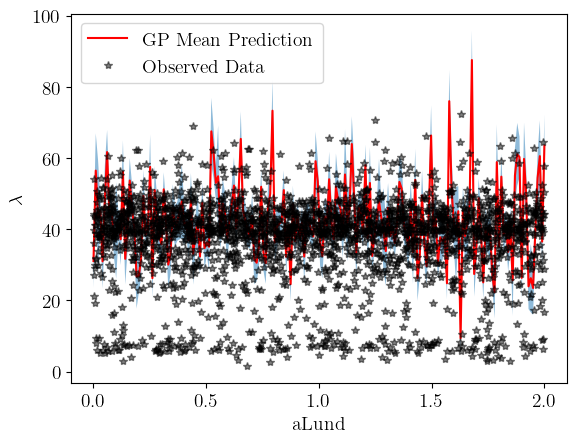

In [454]:
plot_model_param(model, 'aLund')

In [455]:
best_observed_params =get_observed_best_parameters(model)
best_observed_params

{'aLund': 0.6800000071525574,
 'bLund': 0.9800000190734863,
 'rFactC': 1.3200000524520874,
 'rFactB': 0.8550000190734863,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.9700000286102295,
 'sigma': 0.33500000834465027,
 'enhancedFraction': 0.009999999776482582,
 'enhancedWidth': 2.0,
 'ProbStoUD': 0.21699999272823334,
 'probQQtoQ': 0.08100000023841858,
 'probSQtoQQ': 0.9150000214576721,
 'ProbQQ1toQQ0': 0.027499999850988388,
 'alphaSvalue': 0.13650000095367432,
 'pTmin': 0.5}